In [1]:
import os 
 
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Initialisation de constantes
batch_size = 16 # taille de l'échantillon dont les erreurs de prédiction servent à maj les paramètres
latent_dim = 32 # trop faible = compression extrême rendant illisible l'image
                # trop élevé = reconstruction fidèle mais s'écarte de l'objectif de compression lié à l'usage d'un VAE
kl_weight = 0.5 # trop faible = reconstruction impeccable des données mais aucun pouvoir d'échantillonnage
                # trop élevé = reconstruction bruitée
num_classes = 10 # vérifier le nombre de classes dans les données (par défaut 10)
dim_params = 784 # vérifier les dimensions de vos images (H*W)
seed = 0xffff

In [4]:
# Chargement des packages
import jax
import flax
import optax
# import orbax

import flax.linen as nn
import jax.numpy as jnp
from jax.typing import ArrayLike

from typing import Tuple, Callable
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

key = jax.random.PRNGKey(seed)

In [5]:
# from src.data_modeling.VAE import FeedForward
from src.data_modeling.VAE import VAE
from src.data_modeling.train import generate_train_step
from src.data_processing import prepare_test_set
from src.data_processing import get__y_true

In [6]:
import torchvision.transforms as T # message d'erreur : à ignorer
from torchvision.datasets import MNIST
# from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
#from torchvision.transforms import Grayscale
#import torch

C:\ProgramData\anaconda3\envs\keras_jax\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
train_dataset = MNIST('../data', train = True, transform=T.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) 

In [8]:
key, model_key = jax.random.split(key)

model = VAE(latent_dim=latent_dim)
optimizer = optax.adamw(learning_rate=1e-4)

train_step, train, params, opt_state = generate_train_step(model_key, model, optimizer, batch_size=batch_size, num_classes=num_classes, dim_params=dim_params)

In [9]:
params, opt_state = train(key, params, freq=500, epochs=10, opt_state=opt_state, train_loader=train_loader, batch_size=batch_size, train_step=train_step)

Epoch 0 | étape 500 | loss = 36.55783462524414 ~ mse = 36.24393081665039. kl = 0.31390076875686646
Epoch 0 | étape 1000 | loss = 28.37625503540039 ~ mse = 28.00140380859375. kl = 0.3748699128627777
Epoch 0 | étape 1500 | loss = 25.30596923828125 ~ mse = 24.7032527923584. kl = 0.6027082800865173
Epoch 0 | étape 2000 | loss = 23.696937561035156 ~ mse = 23.053110122680664. kl = 0.6438288688659668
Epoch 0 | étape 2500 | loss = 22.61939811706543 ~ mse = 22.02173614501953. kl = 0.5976674556732178
Epoch 0 | étape 3000 | loss = 22.150775909423828 ~ mse = 21.581985473632812. kl = 0.5687988996505737
Epoch 0 | étape 3500 | loss = 21.764497756958008 ~ mse = 21.179914474487305. kl = 0.5845811367034912
Epoch 1 | étape 500 | loss = 21.236845016479492 ~ mse = 20.459196090698242. kl = 0.777642011642456
Epoch 1 | étape 1000 | loss = 20.923961639404297 ~ mse = 20.046642303466797. kl = 0.877307653427124
Epoch 1 | étape 1500 | loss = 20.78485679626465 ~ mse = 19.859207153320312. kl = 0.9256515502929688
Epo

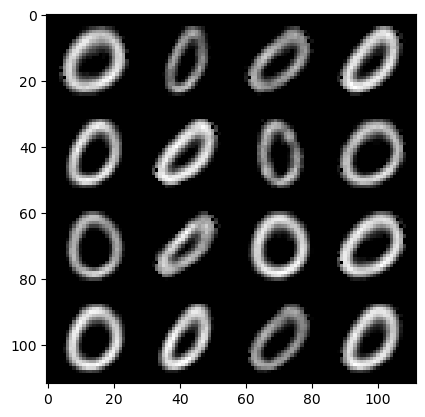

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
model.img_gen(key, params, n_classes=num_classes, img_class=0, h=4, w=4)

In [11]:
test_dataset = MNIST('data', train = False, transform=T.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
total_loss, total_mse, total_kl, loss_distrib = model.evaluate(key, params, n_classes=num_classes, data_loader=test_loader, batch_size=batch_size, get_loss_distrib=True)

Loss totale moyenne = 16.99862289428711
MSE totale moyenne = 14.30423641204834
kl totale moyenne = 2.6943914890289307


In [13]:
class_of_ref = 0
quantile = 0.99 # par défaut, bien que la valeur devrait être tunée via des méthodes de cross-validation


img = prepare_test_set(test_loader.dataset, class_of_ref, mixed_classes=True)
    
thresh = jnp.quantile(jnp.asarray(loss_distrib), quantile)
anomalies = model.det_anom(key, params, img, n_classes=num_classes, tested_class=class_of_ref, threshold=thresh)

Image 0 | loss = 49.677398681640625 ~ mse = 47.728424072265625. kl = 1.9489749670028687
Image 1 | loss = 48.82600784301758 ~ mse = 46.641456604003906. kl = 2.184551239013672
Image 2 | loss = 43.8281364440918 ~ mse = 42.14537811279297. kl = 1.6827589273452759
Image 3 | loss = 21.08338165283203 ~ mse = 18.266395568847656. kl = 2.8169870376586914
Image 4 | loss = 47.949520111083984 ~ mse = 45.38458251953125. kl = 2.5649380683898926
Image 5 | loss = 51.05708312988281 ~ mse = 49.47574234008789. kl = 1.581341028213501
Image 6 | loss = 54.3429069519043 ~ mse = 52.9970703125. kl = 1.3458380699157715
Image 7 | loss = 43.29399871826172 ~ mse = 39.725730895996094. kl = 3.5682666301727295
Image 8 | loss = 46.57864761352539 ~ mse = 45.209144592285156. kl = 1.3695043325424194
Image 9 | loss = 47.18157958984375 ~ mse = 44.02333068847656. kl = 3.158250570297241
Image 10 | loss = 15.423199653625488 ~ mse = 12.533028602600098. kl = 2.8901710510253906
Image 11 | loss = 40.65571594238281 ~ mse = 37.900459

Image 97 | loss = 50.79792404174805 ~ mse = 47.0467529296875. kl = 3.7511706352233887
Image 98 | loss = 36.17704391479492 ~ mse = 34.01567840576172. kl = 2.1613643169403076
Image 99 | loss = 61.5738525390625 ~ mse = 58.453033447265625. kl = 3.1208176612854004
Image 100 | loss = 36.991817474365234 ~ mse = 34.021385192871094. kl = 2.9704339504241943
Image 101 | loss = 15.386540412902832 ~ mse = 12.663797378540039. kl = 2.722743272781372
Image 102 | loss = 45.557655334472656 ~ mse = 43.364173889160156. kl = 2.1934804916381836
Image 103 | loss = 57.23659133911133 ~ mse = 54.71799087524414. kl = 2.5185999870300293
Image 104 | loss = 38.89320373535156 ~ mse = 34.647422790527344. kl = 4.245781421661377
Image 105 | loss = 46.883548736572266 ~ mse = 44.67736053466797. kl = 2.2061872482299805
Image 106 | loss = 46.821632385253906 ~ mse = 44.54993438720703. kl = 2.2716972827911377
Image 107 | loss = 39.73663330078125 ~ mse = 37.94528579711914. kl = 1.7913479804992676
Image 108 | loss = 41.9581184

Image 190 | loss = 55.134239196777344 ~ mse = 52.7602653503418. kl = 2.3739750385284424
Image 191 | loss = 44.576114654541016 ~ mse = 41.11659240722656. kl = 3.4595212936401367
Image 192 | loss = 14.777411460876465 ~ mse = 11.93646240234375. kl = 2.840949058532715
Image 193 | loss = 42.927791595458984 ~ mse = 39.83863830566406. kl = 3.089153528213501
Image 194 | loss = 16.162160873413086 ~ mse = 13.340803146362305. kl = 2.8213577270507812
Image 195 | loss = 30.535417556762695 ~ mse = 27.539941787719727. kl = 2.9954755306243896
Image 196 | loss = 59.014530181884766 ~ mse = 57.29339599609375. kl = 1.7211341857910156
Image 197 | loss = 41.039756774902344 ~ mse = 38.15938186645508. kl = 2.8803744316101074
Image 198 | loss = 46.027889251708984 ~ mse = 43.97999572753906. kl = 2.0478944778442383
Image 199 | loss = 51.68135452270508 ~ mse = 48.31446838378906. kl = 3.366884708404541
Image 200 | loss = 56.72652053833008 ~ mse = 52.50342559814453. kl = 4.223094940185547
Image 201 | loss = 36.9288

Image 287 | loss = 64.97804260253906 ~ mse = 60.65613555908203. kl = 4.321905136108398
Image 288 | loss = 52.774383544921875 ~ mse = 51.38336181640625. kl = 1.3910202980041504
Image 289 | loss = 35.49620819091797 ~ mse = 32.81062316894531. kl = 2.6855835914611816
Image 290 | loss = 47.037445068359375 ~ mse = 43.97185134887695. kl = 3.0655932426452637
Image 291 | loss = 44.210052490234375 ~ mse = 42.40650939941406. kl = 1.803543210029602
Image 292 | loss = 53.663780212402344 ~ mse = 51.295475006103516. kl = 2.368305206298828
Image 293 | loss = 66.08856201171875 ~ mse = 64.35919189453125. kl = 1.7293727397918701
Image 294 | loss = 17.31586456298828 ~ mse = 14.348068237304688. kl = 2.9677958488464355
Image 295 | loss = 49.591896057128906 ~ mse = 46.170166015625. kl = 3.4217281341552734
Image 296 | loss = 15.288152694702148 ~ mse = 11.866863250732422. kl = 3.4212889671325684
Image 297 | loss = 19.113483428955078 ~ mse = 14.884971618652344. kl = 4.228512763977051
Image 298 | loss = 50.84073

Image 383 | loss = 36.53546905517578 ~ mse = 34.44971466064453. kl = 2.085752487182617
Image 384 | loss = 43.21254348754883 ~ mse = 39.9140510559082. kl = 3.2984933853149414
Image 385 | loss = 44.91783142089844 ~ mse = 43.15106964111328. kl = 1.7667632102966309
Image 386 | loss = 35.57318115234375 ~ mse = 33.65119171142578. kl = 1.9219913482666016
Image 387 | loss = 38.28459930419922 ~ mse = 35.97282409667969. kl = 2.3117737770080566
Image 388 | loss = 44.294044494628906 ~ mse = 41.9520263671875. kl = 2.3420169353485107
Image 389 | loss = 54.73843765258789 ~ mse = 51.5909423828125. kl = 3.147496223449707
Image 390 | loss = 46.87911605834961 ~ mse = 43.41825866699219. kl = 3.4608583450317383
Image 391 | loss = 45.61265182495117 ~ mse = 43.793495178222656. kl = 1.819156289100647
Image 392 | loss = 43.18006134033203 ~ mse = 40.8570556640625. kl = 2.3230061531066895
Image 393 | loss = 45.064186096191406 ~ mse = 43.606109619140625. kl = 1.458077311515808
Image 394 | loss = 31.68719863891601

Image 480 | loss = 45.331180572509766 ~ mse = 43.488136291503906. kl = 1.8430449962615967
Image 481 | loss = 46.7357177734375 ~ mse = 44.12763214111328. kl = 2.6080856323242188
Image 482 | loss = 51.856990814208984 ~ mse = 49.537193298339844. kl = 2.319796085357666
Image 483 | loss = 25.61001205444336 ~ mse = 22.567150115966797. kl = 3.0428614616394043
Image 484 | loss = 47.25509262084961 ~ mse = 45.363243103027344. kl = 1.8918510675430298
Image 485 | loss = 14.87991714477539 ~ mse = 12.27773666381836. kl = 2.6021807193756104
Image 486 | loss = 50.77054214477539 ~ mse = 48.92426300048828. kl = 1.8462779521942139
Image 487 | loss = 53.7249755859375 ~ mse = 51.84184265136719. kl = 1.8831347227096558
Image 488 | loss = 46.272972106933594 ~ mse = 44.31686019897461. kl = 1.9561132192611694
Image 489 | loss = 43.72294998168945 ~ mse = 42.004905700683594. kl = 1.7180448770523071
Image 490 | loss = 20.47024917602539 ~ mse = 13.937920570373535. kl = 6.5323286056518555
Image 491 | loss = 31.6681

Image 576 | loss = 47.3909912109375 ~ mse = 45.48980712890625. kl = 1.9011824131011963
Image 577 | loss = 42.631988525390625 ~ mse = 40.4864387512207. kl = 2.1455485820770264
Image 578 | loss = 43.400699615478516 ~ mse = 41.695335388183594. kl = 1.7053624391555786
Image 579 | loss = 43.45161819458008 ~ mse = 41.466583251953125. kl = 1.9850351810455322
Image 580 | loss = 52.58638000488281 ~ mse = 48.706825256347656. kl = 3.8795557022094727
Image 581 | loss = 21.888233184814453 ~ mse = 18.833845138549805. kl = 3.0543887615203857
Image 582 | loss = 33.86007308959961 ~ mse = 31.702030181884766. kl = 2.158043146133423
Image 583 | loss = 48.8105583190918 ~ mse = 47.165279388427734. kl = 1.645279049873352
Image 584 | loss = 54.414546966552734 ~ mse = 52.743255615234375. kl = 1.6712912321090698
Image 585 | loss = 48.695068359375 ~ mse = 46.21099090576172. kl = 2.484076976776123
Image 586 | loss = 16.030210494995117 ~ mse = 13.395627975463867. kl = 2.634582996368408
Image 587 | loss = 60.516376

Image 672 | loss = 49.9526252746582 ~ mse = 48.44522476196289. kl = 1.5074023008346558
Image 673 | loss = 38.208438873291016 ~ mse = 33.9957275390625. kl = 4.212710857391357
Image 674 | loss = 42.22209167480469 ~ mse = 40.03118133544922. kl = 2.1909122467041016
Image 675 | loss = 50.148807525634766 ~ mse = 48.76997375488281. kl = 1.3788337707519531
Image 676 | loss = 53.52842712402344 ~ mse = 50.672157287597656. kl = 2.8562681674957275
Image 677 | loss = 58.940608978271484 ~ mse = 54.27996063232422. kl = 4.66064977645874
Image 678 | loss = 57.10529327392578 ~ mse = 54.493431091308594. kl = 2.6118640899658203
Image 679 | loss = 43.20348358154297 ~ mse = 40.27090835571289. kl = 2.932575225830078
Image 680 | loss = 65.7880859375 ~ mse = 62.917755126953125. kl = 2.870328903198242
Image 681 | loss = 63.86119079589844 ~ mse = 60.39344787597656. kl = 3.467742919921875
Image 682 | loss = 48.2490234375 ~ mse = 46.68239974975586. kl = 1.5666227340698242
Image 683 | loss = 32.60486602783203 ~ mse

Image 766 | loss = 53.01073455810547 ~ mse = 49.304569244384766. kl = 3.706165313720703
Image 767 | loss = 43.24284362792969 ~ mse = 41.18180847167969. kl = 2.0610361099243164
Image 768 | loss = 54.02559280395508 ~ mse = 52.61264419555664. kl = 1.412949800491333
Image 769 | loss = 36.86801528930664 ~ mse = 34.742889404296875. kl = 2.1251256465911865
Image 770 | loss = 52.47270965576172 ~ mse = 49.72059631347656. kl = 2.7521119117736816
Image 771 | loss = 52.55029296875 ~ mse = 49.563743591308594. kl = 2.9865496158599854
Image 772 | loss = 48.82830810546875 ~ mse = 47.39051818847656. kl = 1.4377892017364502
Image 773 | loss = 44.44345474243164 ~ mse = 42.08732223510742. kl = 2.3561341762542725
Image 774 | loss = 30.828420639038086 ~ mse = 28.27676773071289. kl = 2.5516531467437744
Image 775 | loss = 56.579219818115234 ~ mse = 54.289642333984375. kl = 2.289578676223755
Image 776 | loss = 70.8207778930664 ~ mse = 67.43326568603516. kl = 3.3875112533569336
Image 777 | loss = 61.64804840087

Image 861 | loss = 34.038570404052734 ~ mse = 31.187419891357422. kl = 2.8511500358581543
Image 862 | loss = 45.850425720214844 ~ mse = 43.34791564941406. kl = 2.5025103092193604
Image 863 | loss = 38.74766540527344 ~ mse = 36.307945251464844. kl = 2.4397213459014893
Image 864 | loss = 54.55034637451172 ~ mse = 49.78550720214844. kl = 4.764837265014648
Image 865 | loss = 39.79957962036133 ~ mse = 36.55755615234375. kl = 3.2420244216918945
Image 866 | loss = 42.808563232421875 ~ mse = 40.7843017578125. kl = 2.0242629051208496
Image 867 | loss = 47.304752349853516 ~ mse = 44.510990142822266. kl = 2.7937636375427246
Image 868 | loss = 50.36381912231445 ~ mse = 48.93964385986328. kl = 1.4241740703582764
Image 869 | loss = 54.890167236328125 ~ mse = 50.48931884765625. kl = 4.400850296020508
Image 870 | loss = 31.416717529296875 ~ mse = 29.370563507080078. kl = 2.046154737472534
Image 871 | loss = 14.11400032043457 ~ mse = 10.906988143920898. kl = 3.20701265335083
Image 872 | loss = 46.10978

Image 956 | loss = 48.2060432434082 ~ mse = 45.26942443847656. kl = 2.9366185665130615
Image 957 | loss = 36.84148025512695 ~ mse = 34.94274139404297. kl = 1.8987396955490112
Image 958 | loss = 35.522850036621094 ~ mse = 32.61931610107422. kl = 2.903533458709717
Image 959 | loss = 30.6680908203125 ~ mse = 27.2464599609375. kl = 3.421630382537842
Image 960 | loss = 36.71279525756836 ~ mse = 33.866127014160156. kl = 2.846669912338257
Image 961 | loss = 42.481929779052734 ~ mse = 40.347137451171875. kl = 2.134793281555176
Image 962 | loss = 44.334632873535156 ~ mse = 42.09955978393555. kl = 2.235072374343872
Image 963 | loss = 36.255958557128906 ~ mse = 34.47434616088867. kl = 1.7816134691238403
Image 964 | loss = 37.715858459472656 ~ mse = 35.83340835571289. kl = 1.8824496269226074
Image 965 | loss = 26.237051010131836 ~ mse = 23.943233489990234. kl = 2.2938170433044434
Image 966 | loss = 49.136714935302734 ~ mse = 46.85914611816406. kl = 2.277569055557251
Image 967 | loss = 49.086730957

Image 1049 | loss = 63.95329666137695 ~ mse = 61.62590789794922. kl = 2.327387809753418
Image 1050 | loss = 27.99803924560547 ~ mse = 24.946298599243164. kl = 3.0517406463623047
Image 1051 | loss = 51.60382843017578 ~ mse = 48.73277282714844. kl = 2.871053695678711
Image 1052 | loss = 55.648948669433594 ~ mse = 53.40397644042969. kl = 2.2449707984924316
Image 1053 | loss = 52.812103271484375 ~ mse = 50.405189514160156. kl = 2.4069149494171143
Image 1054 | loss = 48.88112258911133 ~ mse = 47.55992126464844. kl = 1.3212000131607056
Image 1055 | loss = 46.12886047363281 ~ mse = 44.19755554199219. kl = 1.9313040971755981
Image 1056 | loss = 42.303531646728516 ~ mse = 40.37566375732422. kl = 1.9278664588928223
Image 1057 | loss = 45.84425735473633 ~ mse = 43.94031524658203. kl = 1.9039437770843506
Image 1058 | loss = 40.08941650390625 ~ mse = 38.07957458496094. kl = 2.009840726852417
Image 1059 | loss = 50.66746139526367 ~ mse = 47.20269775390625. kl = 3.4647631645202637
Image 1060 | loss =

Image 1141 | loss = 47.4360466003418 ~ mse = 44.637420654296875. kl = 2.798624277114868
Image 1142 | loss = 57.25828552246094 ~ mse = 55.385902404785156. kl = 1.8723814487457275
Image 1143 | loss = 64.55389404296875 ~ mse = 61.18560791015625. kl = 3.3682861328125
Image 1144 | loss = 42.65058898925781 ~ mse = 40.23999786376953. kl = 2.4105923175811768
Image 1145 | loss = 64.7630615234375 ~ mse = 60.37815856933594. kl = 4.384906768798828
Image 1146 | loss = 30.79960823059082 ~ mse = 28.05890464782715. kl = 2.74070405960083
Image 1147 | loss = 50.04057693481445 ~ mse = 44.656944274902344. kl = 5.383632659912109
Image 1148 | loss = 14.997718811035156 ~ mse = 12.178783416748047. kl = 2.8189358711242676
Image 1149 | loss = 55.591156005859375 ~ mse = 52.89690399169922. kl = 2.6942529678344727
Image 1150 | loss = 49.77191925048828 ~ mse = 46.14817810058594. kl = 3.6237428188323975
Image 1151 | loss = 27.09859275817871 ~ mse = 23.69375991821289. kl = 3.404832124710083
Image 1152 | loss = 53.907

Image 1233 | loss = 45.641265869140625 ~ mse = 43.47090148925781. kl = 2.170362949371338
Image 1234 | loss = 38.72724533081055 ~ mse = 36.94236755371094. kl = 1.7848773002624512
Image 1235 | loss = 35.39975357055664 ~ mse = 33.37383270263672. kl = 2.025919198989868
Image 1236 | loss = 42.9573974609375 ~ mse = 41.41363525390625. kl = 1.543761968612671
Image 1237 | loss = 43.966426849365234 ~ mse = 41.29719543457031. kl = 2.6692304611206055
Image 1238 | loss = 49.78327178955078 ~ mse = 48.438255310058594. kl = 1.3450161218643188
Image 1239 | loss = 32.47809600830078 ~ mse = 30.708772659301758. kl = 1.7693227529525757
Image 1240 | loss = 51.5615119934082 ~ mse = 48.70170974731445. kl = 2.8598008155822754
Image 1241 | loss = 43.4908447265625 ~ mse = 39.44560241699219. kl = 4.04524040222168
Image 1242 | loss = 25.87767219543457 ~ mse = 22.90633773803711. kl = 2.971334934234619
Image 1243 | loss = 34.34049987792969 ~ mse = 32.29027557373047. kl = 2.0502254962921143
Image 1244 | loss = 50.296

Image 1329 | loss = 50.21405792236328 ~ mse = 48.78076934814453. kl = 1.4332901239395142
Image 1330 | loss = 63.654300689697266 ~ mse = 59.69544219970703. kl = 3.958859443664551
Image 1331 | loss = 38.20473098754883 ~ mse = 35.59262466430664. kl = 2.6121063232421875
Image 1332 | loss = 42.912200927734375 ~ mse = 39.21398162841797. kl = 3.698220729827881
Image 1333 | loss = 11.489511489868164 ~ mse = 8.423213958740234. kl = 3.066297769546509
Image 1334 | loss = 36.2220458984375 ~ mse = 33.989990234375. kl = 2.2320570945739746
Image 1335 | loss = 53.41389465332031 ~ mse = 50.99794387817383. kl = 2.4159488677978516
Image 1336 | loss = 50.198936462402344 ~ mse = 48.14870071411133. kl = 2.050236940383911
Image 1337 | loss = 54.05241394042969 ~ mse = 51.714073181152344. kl = 2.338341474533081
Image 1338 | loss = 50.46329116821289 ~ mse = 48.977684020996094. kl = 1.4856064319610596
Image 1339 | loss = 41.98829650878906 ~ mse = 39.35003662109375. kl = 2.638258218765259
Image 1340 | loss = 33.7

Image 1425 | loss = 49.65525817871094 ~ mse = 47.72220230102539. kl = 1.9330542087554932
Image 1426 | loss = 40.251895904541016 ~ mse = 38.297096252441406. kl = 1.9548009634017944
Image 1427 | loss = 64.25407409667969 ~ mse = 60.77950668334961. kl = 3.474567413330078
Image 1428 | loss = 56.28366470336914 ~ mse = 52.723854064941406. kl = 3.559812307357788
Image 1429 | loss = 43.45045852661133 ~ mse = 41.04854965209961. kl = 2.4019076824188232
Image 1430 | loss = 57.355987548828125 ~ mse = 55.594268798828125. kl = 1.7617173194885254
Image 1431 | loss = 49.76582336425781 ~ mse = 47.01499938964844. kl = 2.7508246898651123
Image 1432 | loss = 49.311256408691406 ~ mse = 45.882118225097656. kl = 3.4291398525238037
Image 1433 | loss = 44.17839813232422 ~ mse = 40.163639068603516. kl = 4.0147576332092285
Image 1434 | loss = 53.72482681274414 ~ mse = 52.37233352661133. kl = 1.3524935245513916
Image 1435 | loss = 49.698463439941406 ~ mse = 46.13287353515625. kl = 3.5655882358551025
Image 1436 | l

Image 1518 | loss = 62.593238830566406 ~ mse = 59.925880432128906. kl = 2.6673600673675537
Image 1519 | loss = 40.375144958496094 ~ mse = 37.71521759033203. kl = 2.6599268913269043
Image 1520 | loss = 39.857608795166016 ~ mse = 36.106605529785156. kl = 3.7510018348693848
Image 1521 | loss = 36.115501403808594 ~ mse = 33.868858337402344. kl = 2.24664306640625
Image 1522 | loss = 31.135395050048828 ~ mse = 27.930347442626953. kl = 3.2050483226776123
Image 1523 | loss = 45.040225982666016 ~ mse = 42.787601470947266. kl = 2.2526261806488037
Image 1524 | loss = 52.175689697265625 ~ mse = 49.131526947021484. kl = 3.044163703918457
Image 1525 | loss = 36.03369140625 ~ mse = 32.3337516784668. kl = 3.699941635131836
Image 1526 | loss = 37.300086975097656 ~ mse = 33.246089935302734. kl = 4.053996562957764
Image 1527 | loss = 45.94904327392578 ~ mse = 43.944480895996094. kl = 2.004560947418213
Image 1528 | loss = 50.09341812133789 ~ mse = 48.78971862792969. kl = 1.3036991357803345
Image 1529 | lo

Image 1612 | loss = 42.0511474609375 ~ mse = 39.9937744140625. kl = 2.057371139526367
Image 1613 | loss = 54.056983947753906 ~ mse = 51.249725341796875. kl = 2.807260274887085
Image 1614 | loss = 37.37580871582031 ~ mse = 34.690940856933594. kl = 2.6848690509796143
Image 1615 | loss = 54.70793914794922 ~ mse = 51.99640655517578. kl = 2.711534023284912
Image 1616 | loss = 37.37798309326172 ~ mse = 34.408592224121094. kl = 2.9693894386291504
Image 1617 | loss = 44.40757751464844 ~ mse = 41.885467529296875. kl = 2.522108316421509
Image 1618 | loss = 67.03616333007812 ~ mse = 63.62825393676758. kl = 3.407907247543335
Image 1619 | loss = 11.517434120178223 ~ mse = 7.797238826751709. kl = 3.7201952934265137
Image 1620 | loss = 65.86314392089844 ~ mse = 63.28192901611328. kl = 2.5812113285064697
Image 1621 | loss = 24.55197525024414 ~ mse = 20.59280776977539. kl = 3.95916748046875
Image 1622 | loss = 48.39702606201172 ~ mse = 45.88359832763672. kl = 2.5134260654449463
Image 1623 | loss = 23.4

Image 1705 | loss = 45.8240852355957 ~ mse = 43.952423095703125. kl = 1.8716603517532349
Image 1706 | loss = 55.90311050415039 ~ mse = 54.063262939453125. kl = 1.839848518371582
Image 1707 | loss = 48.47536849975586 ~ mse = 46.141075134277344. kl = 2.3342928886413574
Image 1708 | loss = 13.504140853881836 ~ mse = 9.769603729248047. kl = 3.734536647796631
Image 1709 | loss = 26.089702606201172 ~ mse = 22.407058715820312. kl = 3.682643413543701
Image 1710 | loss = 47.940242767333984 ~ mse = 46.032470703125. kl = 1.907773733139038
Image 1711 | loss = 45.296566009521484 ~ mse = 42.736759185791016. kl = 2.5598082542419434
Image 1712 | loss = 32.819252014160156 ~ mse = 30.539947509765625. kl = 2.2793054580688477
Image 1713 | loss = 18.045822143554688 ~ mse = 14.981010437011719. kl = 3.0648114681243896
Image 1714 | loss = 51.1906852722168 ~ mse = 48.47138214111328. kl = 2.7193045616149902
Image 1715 | loss = 49.347412109375 ~ mse = 47.6583251953125. kl = 1.6890884637832642
Image 1716 | loss =

Image 1797 | loss = 47.17414474487305 ~ mse = 43.750457763671875. kl = 3.4236881732940674
Image 1798 | loss = 51.769187927246094 ~ mse = 49.53118896484375. kl = 2.2379989624023438
Image 1799 | loss = 52.24712371826172 ~ mse = 49.98160171508789. kl = 2.2655222415924072
Image 1800 | loss = 45.14481735229492 ~ mse = 41.40442657470703. kl = 3.740391492843628
Image 1801 | loss = 59.2113151550293 ~ mse = 54.15644836425781. kl = 5.054865837097168
Image 1802 | loss = 51.449241638183594 ~ mse = 49.531822204589844. kl = 1.9174201488494873
Image 1803 | loss = 46.757545471191406 ~ mse = 44.54285430908203. kl = 2.214689254760742
Image 1804 | loss = 55.43272018432617 ~ mse = 53.04459762573242. kl = 2.388123035430908
Image 1805 | loss = 48.348915100097656 ~ mse = 45.951236724853516. kl = 2.397679090499878
Image 1806 | loss = 37.53958511352539 ~ mse = 35.076499938964844. kl = 2.4630849361419678
Image 1807 | loss = 20.38390350341797 ~ mse = 17.240869522094727. kl = 3.143033027648926
Image 1808 | loss =

Image 1892 | loss = 23.805259704589844 ~ mse = 19.81068229675293. kl = 3.994576930999756
Image 1893 | loss = 56.02277374267578 ~ mse = 53.32637023925781. kl = 2.6964025497436523
Image 1894 | loss = 38.3477897644043 ~ mse = 35.883296966552734. kl = 2.464494228363037
Image 1895 | loss = 61.459266662597656 ~ mse = 56.77093505859375. kl = 4.688333511352539
Image 1896 | loss = 50.67238998413086 ~ mse = 46.755210876464844. kl = 3.917177677154541
Image 1897 | loss = 50.1420783996582 ~ mse = 48.62226104736328. kl = 1.519816517829895
Image 1898 | loss = 20.184141159057617 ~ mse = 15.717230796813965. kl = 4.4669108390808105
Image 1899 | loss = 38.9649658203125 ~ mse = 35.96875. kl = 2.9962141513824463
Image 1900 | loss = 42.08482360839844 ~ mse = 37.993064880371094. kl = 4.091760158538818
Image 1901 | loss = 33.23862838745117 ~ mse = 30.676467895507812. kl = 2.562159299850464
Image 1902 | loss = 37.787105560302734 ~ mse = 35.19952392578125. kl = 2.587580680847168
Image 1903 | loss = 42.190467834

Image 1988 | loss = 47.50961685180664 ~ mse = 46.0174674987793. kl = 1.4921481609344482
Image 1989 | loss = 48.375587463378906 ~ mse = 45.2796630859375. kl = 3.0959255695343018
Image 1990 | loss = 35.244224548339844 ~ mse = 32.83097839355469. kl = 2.4132468700408936
Image 1991 | loss = 52.606685638427734 ~ mse = 51.11589813232422. kl = 1.490788459777832
Image 1992 | loss = 45.08806610107422 ~ mse = 42.67795181274414. kl = 2.41011381149292
Image 1993 | loss = 49.02302932739258 ~ mse = 45.49517822265625. kl = 3.5278496742248535
Image 1994 | loss = 47.93877410888672 ~ mse = 46.59789276123047. kl = 1.3408827781677246
Image 1995 | loss = 25.947546005249023 ~ mse = 22.32444190979004. kl = 3.6231040954589844
Image 1996 | loss = 46.39921569824219 ~ mse = 44.15657043457031. kl = 2.2426438331604004
Image 1997 | loss = 35.10660934448242 ~ mse = 32.78887939453125. kl = 2.3177297115325928
Image 1998 | loss = 45.586448669433594 ~ mse = 43.49284362792969. kl = 2.0936050415039062
Image 1999 | loss = 3

Image 2081 | loss = 15.406864166259766 ~ mse = 12.839021682739258. kl = 2.567842721939087
Image 2082 | loss = 30.696638107299805 ~ mse = 28.078662872314453. kl = 2.617975950241089
Image 2083 | loss = 48.508113861083984 ~ mse = 46.086360931396484. kl = 2.421753168106079
Image 2084 | loss = 55.95405960083008 ~ mse = 51.801475524902344. kl = 4.152584552764893
Image 2085 | loss = 49.33677673339844 ~ mse = 46.154815673828125. kl = 3.1819629669189453
Image 2086 | loss = 47.847312927246094 ~ mse = 45.284912109375. kl = 2.56240177154541
Image 2087 | loss = 14.310953140258789 ~ mse = 11.109027862548828. kl = 3.201925754547119
Image 2088 | loss = 60.285057067871094 ~ mse = 57.00202178955078. kl = 3.28303599357605
Image 2089 | loss = 40.89848709106445 ~ mse = 37.32658386230469. kl = 3.571901798248291
Image 2090 | loss = 36.26657485961914 ~ mse = 32.55658721923828. kl = 3.709986686706543
Image 2091 | loss = 66.95429992675781 ~ mse = 63.49739456176758. kl = 3.4569027423858643
Image 2092 | loss = 45

Image 2173 | loss = 57.793025970458984 ~ mse = 55.777305603027344. kl = 2.0157203674316406
Image 2174 | loss = 36.418678283691406 ~ mse = 34.016353607177734. kl = 2.4023237228393555
Image 2175 | loss = 37.166316986083984 ~ mse = 35.43717575073242. kl = 1.729142189025879
Image 2176 | loss = 34.70405960083008 ~ mse = 32.71855926513672. kl = 1.9854985475540161
Image 2177 | loss = 52.45501708984375 ~ mse = 49.22517776489258. kl = 3.229839324951172
Image 2178 | loss = 14.8983154296875 ~ mse = 12.138957977294922. kl = 2.759357452392578
Image 2179 | loss = 51.46821594238281 ~ mse = 50.086124420166016. kl = 1.3820900917053223
Image 2180 | loss = 44.909053802490234 ~ mse = 41.87195587158203. kl = 3.0370984077453613
Image 2181 | loss = 55.472469329833984 ~ mse = 52.34574890136719. kl = 3.1267201900482178
Image 2182 | loss = 52.82270812988281 ~ mse = 50.06688690185547. kl = 2.7558212280273438
Image 2183 | loss = 47.48876190185547 ~ mse = 43.795536041259766. kl = 3.6932268142700195
Image 2184 | lo

Image 2265 | loss = 46.181095123291016 ~ mse = 43.81768035888672. kl = 2.3634138107299805
Image 2266 | loss = 47.5450439453125 ~ mse = 45.288368225097656. kl = 2.2566745281219482
Image 2267 | loss = 42.78134536743164 ~ mse = 40.75170135498047. kl = 2.0296449661254883
Image 2268 | loss = 43.86252975463867 ~ mse = 40.340301513671875. kl = 3.5222280025482178
Image 2269 | loss = 42.16439437866211 ~ mse = 38.372554779052734. kl = 3.7918410301208496
Image 2270 | loss = 45.449459075927734 ~ mse = 43.52344512939453. kl = 1.9260144233703613
Image 2271 | loss = 48.0523681640625 ~ mse = 46.2675666809082. kl = 1.7848007678985596
Image 2272 | loss = 36.855560302734375 ~ mse = 34.0709114074707. kl = 2.784648895263672
Image 2273 | loss = 37.86481475830078 ~ mse = 36.08746337890625. kl = 1.7773497104644775
Image 2274 | loss = 50.84805679321289 ~ mse = 48.79193878173828. kl = 2.0561163425445557
Image 2275 | loss = 43.29743194580078 ~ mse = 41.38182067871094. kl = 1.915611982345581
Image 2276 | loss = 4

Image 2359 | loss = 48.86289978027344 ~ mse = 47.43867874145508. kl = 1.4242205619812012
Image 2360 | loss = 42.298789978027344 ~ mse = 39.7940673828125. kl = 2.5047221183776855
Image 2361 | loss = 34.769752502441406 ~ mse = 32.39070129394531. kl = 2.3790526390075684
Image 2362 | loss = 40.65834045410156 ~ mse = 37.98933792114258. kl = 2.6690008640289307
Image 2363 | loss = 64.90001678466797 ~ mse = 61.964908599853516. kl = 2.9351110458374023
Image 2364 | loss = 44.60056686401367 ~ mse = 42.671051025390625. kl = 1.9295151233673096
Image 2365 | loss = 42.23592758178711 ~ mse = 39.552398681640625. kl = 2.683529853820801
Image 2366 | loss = 50.26438903808594 ~ mse = 48.65911102294922. kl = 1.6052778959274292
Image 2367 | loss = 35.287227630615234 ~ mse = 32.58982467651367. kl = 2.697404146194458
Image 2368 | loss = 47.621158599853516 ~ mse = 45.69775390625. kl = 1.9234048128128052
Image 2369 | loss = 41.37419891357422 ~ mse = 38.37603759765625. kl = 2.9981608390808105
Image 2370 | loss = 

Image 2453 | loss = 32.08744430541992 ~ mse = 29.699623107910156. kl = 2.3878207206726074
Image 2454 | loss = 45.36849594116211 ~ mse = 42.53069305419922. kl = 2.837801933288574
Image 2455 | loss = 20.927873611450195 ~ mse = 18.093658447265625. kl = 2.8342158794403076
Image 2456 | loss = 35.006813049316406 ~ mse = 32.63997268676758. kl = 2.3668386936187744
Image 2457 | loss = 54.67020797729492 ~ mse = 52.54745864868164. kl = 2.1227502822875977
Image 2458 | loss = 46.79740905761719 ~ mse = 44.49978256225586. kl = 2.2976253032684326
Image 2459 | loss = 46.54037857055664 ~ mse = 44.35108947753906. kl = 2.1892876625061035
Image 2460 | loss = 40.05919647216797 ~ mse = 36.99464416503906. kl = 3.0645527839660645
Image 2461 | loss = 14.323878288269043 ~ mse = 11.17068099975586. kl = 3.1531972885131836
Image 2462 | loss = 39.67875671386719 ~ mse = 32.289642333984375. kl = 7.3891143798828125
Image 2463 | loss = 33.90111541748047 ~ mse = 31.547386169433594. kl = 2.3537282943725586
Image 2464 | lo

Image 2548 | loss = 58.748939514160156 ~ mse = 55.09162139892578. kl = 3.657318353652954
Image 2549 | loss = 44.79619216918945 ~ mse = 42.36723327636719. kl = 2.428959369659424
Image 2550 | loss = 43.932472229003906 ~ mse = 41.751651763916016. kl = 2.180821180343628
Image 2551 | loss = 44.64185333251953 ~ mse = 42.73308563232422. kl = 1.9087661504745483
Image 2552 | loss = 49.2617073059082 ~ mse = 46.58207702636719. kl = 2.6796300411224365
Image 2553 | loss = 46.41862106323242 ~ mse = 45.06239318847656. kl = 1.356229305267334
Image 2554 | loss = 35.38939666748047 ~ mse = 32.261959075927734. kl = 3.127437114715576
Image 2555 | loss = 48.123558044433594 ~ mse = 45.72655487060547. kl = 2.397003412246704
Image 2556 | loss = 39.005001068115234 ~ mse = 36.06697463989258. kl = 2.9380273818969727
Image 2557 | loss = 18.499906539916992 ~ mse = 15.533407211303711. kl = 2.966498851776123
Image 2558 | loss = 38.7772216796875 ~ mse = 36.94945526123047. kl = 1.8277667760849
Image 2559 | loss = 41.45

Image 2640 | loss = 37.32314682006836 ~ mse = 35.59210968017578. kl = 1.731035828590393
Image 2641 | loss = 27.1092472076416 ~ mse = 24.277568817138672. kl = 2.8316776752471924
Image 2642 | loss = 41.864288330078125 ~ mse = 39.79905700683594. kl = 2.065232753753662
Image 2643 | loss = 50.33388900756836 ~ mse = 48.7462043762207. kl = 1.5876843929290771
Image 2644 | loss = 28.40553092956543 ~ mse = 26.531431198120117. kl = 1.8741003274917603
Image 2645 | loss = 40.50553894042969 ~ mse = 38.42828369140625. kl = 2.077256441116333
Image 2646 | loss = 40.21873474121094 ~ mse = 37.77347946166992. kl = 2.4452552795410156
Image 2647 | loss = 33.983497619628906 ~ mse = 31.38260841369629. kl = 2.600889205932617
Image 2648 | loss = 29.011629104614258 ~ mse = 27.025283813476562. kl = 1.9863444566726685
Image 2649 | loss = 23.73251724243164 ~ mse = 17.70807647705078. kl = 6.024441242218018
Image 2650 | loss = 27.712888717651367 ~ mse = 25.304964065551758. kl = 2.4079248905181885
Image 2651 | loss = 

Image 2735 | loss = 31.799598693847656 ~ mse = 29.200546264648438. kl = 2.5990524291992188
Image 2736 | loss = 38.13862228393555 ~ mse = 35.757816314697266. kl = 2.380805730819702
Image 2737 | loss = 44.149959564208984 ~ mse = 41.932369232177734. kl = 2.217589855194092
Image 2738 | loss = 53.18067169189453 ~ mse = 49.219600677490234. kl = 3.9610700607299805
Image 2739 | loss = 49.54166030883789 ~ mse = 46.88993835449219. kl = 2.6517231464385986
Image 2740 | loss = 40.98381042480469 ~ mse = 38.37700271606445. kl = 2.606809139251709
Image 2741 | loss = 48.92241287231445 ~ mse = 47.26090621948242. kl = 1.661508321762085
Image 2742 | loss = 54.08760452270508 ~ mse = 50.910911560058594. kl = 3.176692008972168
Image 2743 | loss = 24.36702537536621 ~ mse = 21.91965103149414. kl = 2.4473750591278076
Image 2744 | loss = 43.96765899658203 ~ mse = 42.23994064331055. kl = 1.727720022201538
Image 2745 | loss = 48.218570709228516 ~ mse = 46.17328643798828. kl = 2.0452828407287598
Image 2746 | loss =

Image 2827 | loss = 39.31687545776367 ~ mse = 37.25888442993164. kl = 2.0579919815063477
Image 2828 | loss = 50.20991516113281 ~ mse = 47.945560455322266. kl = 2.264355421066284
Image 2829 | loss = 33.631256103515625 ~ mse = 30.985855102539062. kl = 2.6454005241394043
Image 2830 | loss = 59.33731460571289 ~ mse = 54.156761169433594. kl = 5.1805524826049805
Image 2831 | loss = 46.16777420043945 ~ mse = 43.58036422729492. kl = 2.5874109268188477
Image 2832 | loss = 44.982330322265625 ~ mse = 42.745243072509766. kl = 2.237086534500122
Image 2833 | loss = 57.574588775634766 ~ mse = 54.261329650878906. kl = 3.3132593631744385
Image 2834 | loss = 48.483253479003906 ~ mse = 45.29347610473633. kl = 3.189779281616211
Image 2835 | loss = 41.44419860839844 ~ mse = 39.32691192626953. kl = 2.1172878742218018
Image 2836 | loss = 53.59025192260742 ~ mse = 51.4356689453125. kl = 2.1545822620391846
Image 2837 | loss = 55.54228973388672 ~ mse = 53.15715026855469. kl = 2.3851397037506104
Image 2838 | los

Image 2920 | loss = 36.775325775146484 ~ mse = 33.72010040283203. kl = 3.055225372314453
Image 2921 | loss = 29.71226692199707 ~ mse = 27.563772201538086. kl = 2.148494005203247
Image 2922 | loss = 43.43574905395508 ~ mse = 40.948429107666016. kl = 2.487318515777588
Image 2923 | loss = 34.194313049316406 ~ mse = 31.66241455078125. kl = 2.53189754486084
Image 2924 | loss = 40.842857360839844 ~ mse = 38.337974548339844. kl = 2.5048840045928955
Image 2925 | loss = 26.680118560791016 ~ mse = 23.117441177368164. kl = 3.5626773834228516
Image 2926 | loss = 42.885650634765625 ~ mse = 40.91511154174805. kl = 1.9705371856689453
Image 2927 | loss = 53.33263397216797 ~ mse = 48.796348571777344. kl = 4.536285877227783
Image 2928 | loss = 54.407711029052734 ~ mse = 52.81831741333008. kl = 1.589394211769104
Image 2929 | loss = 60.924659729003906 ~ mse = 57.17055892944336. kl = 3.7541019916534424
Image 2930 | loss = 24.79901885986328 ~ mse = 21.642959594726562. kl = 3.156059741973877
Image 2931 | los

Image 3013 | loss = 22.21296501159668 ~ mse = 19.114540100097656. kl = 3.0984244346618652
Image 3014 | loss = 48.07439041137695 ~ mse = 46.28003692626953. kl = 1.7943516969680786
Image 3015 | loss = 49.21942138671875 ~ mse = 47.13477325439453. kl = 2.084646224975586
Image 3016 | loss = 25.254993438720703 ~ mse = 20.66728401184082. kl = 4.587708950042725
Image 3017 | loss = 46.590354919433594 ~ mse = 44.73612976074219. kl = 1.8542248010635376
Image 3018 | loss = 32.4044303894043 ~ mse = 30.22305679321289. kl = 2.1813719272613525
Image 3019 | loss = 42.22111129760742 ~ mse = 40.299339294433594. kl = 1.9217734336853027
Image 3020 | loss = 14.950031280517578 ~ mse = 10.092893600463867. kl = 4.857138156890869
Image 3021 | loss = 56.96324157714844 ~ mse = 55.18067169189453. kl = 1.7825710773468018
Image 3022 | loss = 37.92152786254883 ~ mse = 36.270790100097656. kl = 1.6507370471954346
Image 3023 | loss = 54.92121887207031 ~ mse = 52.43659973144531. kl = 2.484619617462158
Image 3024 | loss =

Image 3105 | loss = 58.98623275756836 ~ mse = 56.923805236816406. kl = 2.062427043914795
Image 3106 | loss = 33.953758239746094 ~ mse = 31.88351058959961. kl = 2.0702476501464844
Image 3107 | loss = 53.415653228759766 ~ mse = 50.77935791015625. kl = 2.636294364929199
Image 3108 | loss = 37.4481201171875 ~ mse = 34.61229705810547. kl = 2.835824489593506
Image 3109 | loss = 28.068702697753906 ~ mse = 24.794422149658203. kl = 3.274280071258545
Image 3110 | loss = 38.383338928222656 ~ mse = 35.381187438964844. kl = 3.00215220451355
Image 3111 | loss = 37.56903839111328 ~ mse = 34.952728271484375. kl = 2.616312026977539
Image 3112 | loss = 42.766761779785156 ~ mse = 40.24449157714844. kl = 2.5222716331481934
Image 3113 | loss = 31.70832061767578 ~ mse = 29.476734161376953. kl = 2.2315869331359863
Image 3114 | loss = 48.13225555419922 ~ mse = 45.41655731201172. kl = 2.715696334838867
Image 3115 | loss = 28.126070022583008 ~ mse = 25.259971618652344. kl = 2.8660988807678223
Image 3116 | loss 

Image 3198 | loss = 64.66496276855469 ~ mse = 62.60247039794922. kl = 2.062494993209839
Image 3199 | loss = 31.27086067199707 ~ mse = 29.026823043823242. kl = 2.2440381050109863
Image 3200 | loss = 61.122867584228516 ~ mse = 57.67719268798828. kl = 3.44567608833313
Image 3201 | loss = 49.817142486572266 ~ mse = 47.064453125. kl = 2.7526907920837402
Image 3202 | loss = 45.90801239013672 ~ mse = 43.867271423339844. kl = 2.0407397747039795
Image 3203 | loss = 40.66287612915039 ~ mse = 38.78993606567383. kl = 1.8729406595230103
Image 3204 | loss = 45.807186126708984 ~ mse = 43.993080139160156. kl = 1.8141077756881714
Image 3205 | loss = 43.4302978515625 ~ mse = 40.87869644165039. kl = 2.5516016483306885
Image 3206 | loss = 36.9431266784668 ~ mse = 35.121978759765625. kl = 1.8211491107940674
Image 3207 | loss = 34.87579345703125 ~ mse = 32.59873962402344. kl = 2.277052402496338
Image 3208 | loss = 50.43798065185547 ~ mse = 48.469261169433594. kl = 1.9687186479568481
Image 3209 | loss = 43.1

Image 3291 | loss = 58.96593475341797 ~ mse = 56.18611145019531. kl = 2.7798233032226562
Image 3292 | loss = 43.64519119262695 ~ mse = 41.12189483642578. kl = 2.5232961177825928
Image 3293 | loss = 68.08588409423828 ~ mse = 65.64324188232422. kl = 2.4426417350769043
Image 3294 | loss = 66.81014251708984 ~ mse = 65.16447448730469. kl = 1.6456682682037354
Image 3295 | loss = 46.948158264160156 ~ mse = 43.72885513305664. kl = 3.219304084777832
Image 3296 | loss = 52.32283401489258 ~ mse = 50.068603515625. kl = 2.2542307376861572
Image 3297 | loss = 21.833980560302734 ~ mse = 19.260208129882812. kl = 2.5737721920013428
Image 3298 | loss = 37.018035888671875 ~ mse = 34.5436897277832. kl = 2.4743449687957764
Image 3299 | loss = 42.25407791137695 ~ mse = 39.37012481689453. kl = 2.88395357131958
Image 3300 | loss = 46.09659957885742 ~ mse = 42.926536560058594. kl = 3.170063018798828
Image 3301 | loss = 45.79496383666992 ~ mse = 43.40538787841797. kl = 2.389577627182007
Image 3302 | loss = 32.7

Image 3384 | loss = 30.25489616394043 ~ mse = 27.167133331298828. kl = 3.087763547897339
Image 3385 | loss = 56.009239196777344 ~ mse = 52.74419403076172. kl = 3.265047073364258
Image 3386 | loss = 44.27134323120117 ~ mse = 42.67389678955078. kl = 1.5974482297897339
Image 3387 | loss = 46.78476333618164 ~ mse = 43.91147232055664. kl = 2.8732893466949463
Image 3388 | loss = 36.962154388427734 ~ mse = 34.374168395996094. kl = 2.5879857540130615
Image 3389 | loss = 48.429046630859375 ~ mse = 45.22019958496094. kl = 3.208848237991333
Image 3390 | loss = 46.30363464355469 ~ mse = 44.29894256591797. kl = 2.004690647125244
Image 3391 | loss = 39.10890197753906 ~ mse = 36.637237548828125. kl = 2.471663475036621
Image 3392 | loss = 44.73855209350586 ~ mse = 42.74092102050781. kl = 1.9976317882537842
Image 3393 | loss = 40.51001739501953 ~ mse = 38.668479919433594. kl = 1.841538667678833
Image 3394 | loss = 56.31059265136719 ~ mse = 51.12299346923828. kl = 5.187600612640381
Image 3395 | loss = 4

Image 3479 | loss = 19.44251823425293 ~ mse = 15.578215599060059. kl = 3.8643033504486084
Image 3480 | loss = 58.43082809448242 ~ mse = 56.230430603027344. kl = 2.2003989219665527
Image 3481 | loss = 12.334596633911133 ~ mse = 9.1622314453125. kl = 3.172365665435791
Image 3482 | loss = 48.109825134277344 ~ mse = 46.43309020996094. kl = 1.676734209060669
Image 3483 | loss = 51.02233123779297 ~ mse = 47.66771697998047. kl = 3.3546159267425537
Image 3484 | loss = 48.59251022338867 ~ mse = 46.694175720214844. kl = 1.8983356952667236
Image 3485 | loss = 49.193321228027344 ~ mse = 46.535404205322266. kl = 2.6579184532165527
Image 3486 | loss = 46.19552993774414 ~ mse = 42.938751220703125. kl = 3.256779432296753
Image 3487 | loss = 41.690635681152344 ~ mse = 39.1650276184082. kl = 2.5256099700927734
Image 3488 | loss = 48.08628845214844 ~ mse = 45.085330963134766. kl = 3.000955820083618
Image 3489 | loss = 50.475059509277344 ~ mse = 48.78280258178711. kl = 1.692257046699524
Image 3490 | loss 

Image 3572 | loss = 43.17184829711914 ~ mse = 41.38203048706055. kl = 1.7898164987564087
Image 3573 | loss = 47.85273742675781 ~ mse = 46.095916748046875. kl = 1.7568199634552002
Image 3574 | loss = 19.963600158691406 ~ mse = 17.437522888183594. kl = 2.526076316833496
Image 3575 | loss = 43.552574157714844 ~ mse = 40.31831741333008. kl = 3.234255790710449
Image 3576 | loss = 52.55109405517578 ~ mse = 51.0051383972168. kl = 1.5459542274475098
Image 3577 | loss = 35.86954879760742 ~ mse = 33.2487907409668. kl = 2.620758295059204
Image 3578 | loss = 35.617271423339844 ~ mse = 32.959327697753906. kl = 2.657942771911621
Image 3579 | loss = 57.214481353759766 ~ mse = 53.989376068115234. kl = 3.225104808807373
Image 3580 | loss = 46.90576934814453 ~ mse = 42.8529052734375. kl = 4.052865505218506
Image 3581 | loss = 19.79819679260254 ~ mse = 17.158180236816406. kl = 2.640017032623291
Image 3582 | loss = 50.79541015625 ~ mse = 48.63319778442383. kl = 2.1622138023376465
Image 3583 | loss = 40.20

Image 3664 | loss = 43.34056854248047 ~ mse = 41.352813720703125. kl = 1.9877550601959229
Image 3665 | loss = 45.880287170410156 ~ mse = 40.86089324951172. kl = 5.019392490386963
Image 3666 | loss = 47.18022155761719 ~ mse = 45.351531982421875. kl = 1.828688144683838
Image 3667 | loss = 54.04201126098633 ~ mse = 52.08216094970703. kl = 1.9598498344421387
Image 3668 | loss = 70.74574279785156 ~ mse = 68.40496826171875. kl = 2.340773582458496
Image 3669 | loss = 50.73859786987305 ~ mse = 49.256771087646484. kl = 1.4818272590637207
Image 3670 | loss = 55.86467361450195 ~ mse = 53.684288024902344. kl = 2.180384635925293
Image 3671 | loss = 65.83161926269531 ~ mse = 61.973655700683594. kl = 3.8579659461975098
Image 3672 | loss = 34.68190002441406 ~ mse = 32.41868209838867. kl = 2.2632181644439697
Image 3673 | loss = 46.830909729003906 ~ mse = 45.38078308105469. kl = 1.450127363204956
Image 3674 | loss = 38.67763900756836 ~ mse = 36.36180877685547. kl = 2.315829277038574
Image 3675 | loss = 

Image 3758 | loss = 40.3573112487793 ~ mse = 38.417877197265625. kl = 1.9394327402114868
Image 3759 | loss = 47.14026641845703 ~ mse = 44.62833786010742. kl = 2.511929512023926
Image 3760 | loss = 41.00432205200195 ~ mse = 38.237510681152344. kl = 2.7668118476867676
Image 3761 | loss = 43.53474044799805 ~ mse = 41.58991241455078. kl = 1.9448281526565552
Image 3762 | loss = 25.58355712890625 ~ mse = 22.372886657714844. kl = 3.2106711864471436
Image 3763 | loss = 35.536529541015625 ~ mse = 33.073856353759766. kl = 2.462671995162964
Image 3764 | loss = 23.120849609375 ~ mse = 19.83926010131836. kl = 3.2815892696380615
Image 3765 | loss = 55.30156707763672 ~ mse = 53.74712371826172. kl = 1.5544414520263672
Image 3766 | loss = 45.0428352355957 ~ mse = 42.63669204711914. kl = 2.406141519546509
Image 3767 | loss = 47.69585037231445 ~ mse = 45.552059173583984. kl = 2.1437902450561523
Image 3768 | loss = 25.075389862060547 ~ mse = 19.61492156982422. kl = 5.460467338562012
Image 3769 | loss = 43

Image 3850 | loss = 51.92182922363281 ~ mse = 49.73321533203125. kl = 2.1886146068573
Image 3851 | loss = 35.78742599487305 ~ mse = 34.137413024902344. kl = 1.6500113010406494
Image 3852 | loss = 39.7883415222168 ~ mse = 38.082706451416016. kl = 1.705634355545044
Image 3853 | loss = 27.337533950805664 ~ mse = 25.454898834228516. kl = 1.8826351165771484
Image 3854 | loss = 67.28568267822266 ~ mse = 62.52003479003906. kl = 4.765645503997803
Image 3855 | loss = 34.18613815307617 ~ mse = 31.397235870361328. kl = 2.788900852203369
Image 3856 | loss = 57.5066032409668 ~ mse = 52.639827728271484. kl = 4.866774559020996
Image 3857 | loss = 40.41885757446289 ~ mse = 37.82054138183594. kl = 2.598315954208374
Image 3858 | loss = 42.251075744628906 ~ mse = 40.43217086791992. kl = 1.818906307220459
Image 3859 | loss = 42.863887786865234 ~ mse = 39.47659683227539. kl = 3.3872900009155273
Image 3860 | loss = 38.36576843261719 ~ mse = 35.589046478271484. kl = 2.7767224311828613
Image 3861 | loss = 48.

Image 3944 | loss = 48.76924514770508 ~ mse = 46.891929626464844. kl = 1.8773152828216553
Image 3945 | loss = 53.193695068359375 ~ mse = 51.54436492919922. kl = 1.649330973625183
Image 3946 | loss = 38.73662185668945 ~ mse = 35.124122619628906. kl = 3.6124982833862305
Image 3947 | loss = 47.294002532958984 ~ mse = 45.39405822753906. kl = 1.8999439477920532
Image 3948 | loss = 44.1495246887207 ~ mse = 41.05746841430664. kl = 3.092057466506958
Image 3949 | loss = 46.058353424072266 ~ mse = 44.173828125. kl = 1.8845269680023193
Image 3950 | loss = 47.663841247558594 ~ mse = 44.857887268066406. kl = 2.8059544563293457
Image 3951 | loss = 39.16207504272461 ~ mse = 37.64350891113281. kl = 1.518566608428955
Image 3952 | loss = 35.81279754638672 ~ mse = 33.897911071777344. kl = 1.9148857593536377
Image 3953 | loss = 36.24494934082031 ~ mse = 34.35321807861328. kl = 1.8917301893234253
Image 3954 | loss = 47.6247673034668 ~ mse = 45.4571418762207. kl = 2.167623996734619
Image 3955 | loss = 35.03

Image 4036 | loss = 55.70294952392578 ~ mse = 54.124961853027344. kl = 1.5779868364334106
Image 4037 | loss = 30.474082946777344 ~ mse = 26.76411247253418. kl = 3.7099711894989014
Image 4038 | loss = 38.165157318115234 ~ mse = 35.22356414794922. kl = 2.941594123840332
Image 4039 | loss = 47.62486267089844 ~ mse = 45.975807189941406. kl = 1.6490540504455566
Image 4040 | loss = 51.974632263183594 ~ mse = 49.378257751464844. kl = 2.596374988555908
Image 4041 | loss = 65.35626220703125 ~ mse = 62.308349609375. kl = 3.047912120819092
Image 4042 | loss = 59.86363983154297 ~ mse = 56.39193344116211. kl = 3.471707582473755
Image 4043 | loss = 26.85242462158203 ~ mse = 23.036758422851562. kl = 3.8156652450561523
Image 4044 | loss = 47.390296936035156 ~ mse = 43.67737579345703. kl = 3.7129197120666504
Image 4045 | loss = 44.1197509765625 ~ mse = 41.332618713378906. kl = 2.7871339321136475
Image 4046 | loss = 56.34629821777344 ~ mse = 53.75646209716797. kl = 2.589834213256836
Image 4047 | loss = 

Image 4132 | loss = 31.73476219177246 ~ mse = 29.548587799072266. kl = 2.186173915863037
Image 4133 | loss = 46.77123260498047 ~ mse = 43.97021484375. kl = 2.8010177612304688
Image 4134 | loss = 42.97148132324219 ~ mse = 40.951019287109375. kl = 2.0204620361328125
Image 4135 | loss = 33.587867736816406 ~ mse = 31.408729553222656. kl = 2.1791367530822754
Image 4136 | loss = 49.68580627441406 ~ mse = 47.869712829589844. kl = 1.816094160079956
Image 4137 | loss = 49.1596565246582 ~ mse = 47.61276626586914. kl = 1.5468895435333252
Image 4138 | loss = 54.031436920166016 ~ mse = 52.45458984375. kl = 1.5768483877182007
Image 4139 | loss = 56.80385971069336 ~ mse = 52.89838790893555. kl = 3.9054722785949707
Image 4140 | loss = 55.48909378051758 ~ mse = 52.72507095336914. kl = 2.7640233039855957
Image 4141 | loss = 47.1091423034668 ~ mse = 44.89013671875. kl = 2.219006061553955
Image 4142 | loss = 46.33675765991211 ~ mse = 41.89265060424805. kl = 4.4441070556640625
Image 4143 | loss = 47.822250

Image 4228 | loss = 51.69043731689453 ~ mse = 49.643531799316406. kl = 2.046903610229492
Image 4229 | loss = 67.09432983398438 ~ mse = 64.50731658935547. kl = 2.5870141983032227
Image 4230 | loss = 45.634864807128906 ~ mse = 42.650787353515625. kl = 2.9840774536132812
Image 4231 | loss = 35.678409576416016 ~ mse = 33.642948150634766. kl = 2.0354621410369873
Image 4232 | loss = 44.99824905395508 ~ mse = 43.13661193847656. kl = 1.8616353273391724
Image 4233 | loss = 36.253787994384766 ~ mse = 33.54076385498047. kl = 2.7130258083343506
Image 4234 | loss = 50.0860710144043 ~ mse = 47.969303131103516. kl = 2.1167681217193604
Image 4235 | loss = 40.82597351074219 ~ mse = 38.04847717285156. kl = 2.777496576309204
Image 4236 | loss = 38.8936882019043 ~ mse = 37.147300720214844. kl = 1.746386170387268
Image 4237 | loss = 55.247005462646484 ~ mse = 53.25429916381836. kl = 1.9927054643630981
Image 4238 | loss = 38.6806640625 ~ mse = 36.66913604736328. kl = 2.0115272998809814
Image 4239 | loss = 3

Image 4320 | loss = 15.455219268798828 ~ mse = 11.895684242248535. kl = 3.559535026550293
Image 4321 | loss = 50.79106903076172 ~ mse = 47.827186584472656. kl = 2.963880777359009
Image 4322 | loss = 60.1602668762207 ~ mse = 57.156768798828125. kl = 3.0034987926483154
Image 4323 | loss = 24.74213218688965 ~ mse = 22.059982299804688. kl = 2.682149648666382
Image 4324 | loss = 42.487060546875 ~ mse = 39.439674377441406. kl = 3.04738712310791
Image 4325 | loss = 45.62674331665039 ~ mse = 42.494483947753906. kl = 3.132258415222168
Image 4326 | loss = 65.90172576904297 ~ mse = 64.526123046875. kl = 1.3756053447723389
Image 4327 | loss = 27.29901123046875 ~ mse = 22.88775634765625. kl = 4.411253929138184
Image 4328 | loss = 54.87642288208008 ~ mse = 53.46335220336914. kl = 1.4130711555480957
Image 4329 | loss = 28.23341178894043 ~ mse = 25.90781021118164. kl = 2.32560133934021
Image 4330 | loss = 39.75910186767578 ~ mse = 37.56816864013672. kl = 2.1909313201904297
Image 4331 | loss = 43.11785

Image 4412 | loss = 42.147396087646484 ~ mse = 40.32107162475586. kl = 1.8263226747512817
Image 4413 | loss = 28.490577697753906 ~ mse = 24.048465728759766. kl = 4.442111492156982
Image 4414 | loss = 55.7205810546875 ~ mse = 53.56760025024414. kl = 2.152982711791992
Image 4415 | loss = 41.584503173828125 ~ mse = 38.214168548583984. kl = 3.370333194732666
Image 4416 | loss = 36.6918830871582 ~ mse = 33.303077697753906. kl = 3.388805866241455
Image 4417 | loss = 55.80253982543945 ~ mse = 52.639610290527344. kl = 3.162929058074951
Image 4418 | loss = 61.825618743896484 ~ mse = 60.10811233520508. kl = 1.7175061702728271
Image 4419 | loss = 47.05056381225586 ~ mse = 45.68128967285156. kl = 1.3692744970321655
Image 4420 | loss = 38.141151428222656 ~ mse = 35.85131072998047. kl = 2.289839029312134
Image 4421 | loss = 53.103946685791016 ~ mse = 50.09475326538086. kl = 3.0091922283172607
Image 4422 | loss = 38.44771194458008 ~ mse = 36.57508850097656. kl = 1.8726247549057007
Image 4423 | loss =

Image 4504 | loss = 35.09141540527344 ~ mse = 33.395233154296875. kl = 1.696183443069458
Image 4505 | loss = 60.23026657104492 ~ mse = 54.42597198486328. kl = 5.804296016693115
Image 4506 | loss = 39.08563995361328 ~ mse = 37.26305389404297. kl = 1.8225841522216797
Image 4507 | loss = 43.02070999145508 ~ mse = 40.1927604675293. kl = 2.8279502391815186
Image 4508 | loss = 52.33261489868164 ~ mse = 50.58830642700195. kl = 1.744309663772583
Image 4509 | loss = 41.13759231567383 ~ mse = 37.9312744140625. kl = 3.20631742477417
Image 4510 | loss = 54.66569519042969 ~ mse = 52.691566467285156. kl = 1.9741284847259521
Image 4511 | loss = 56.869937896728516 ~ mse = 52.029502868652344. kl = 4.84043550491333
Image 4512 | loss = 35.873931884765625 ~ mse = 32.92925262451172. kl = 2.9446780681610107
Image 4513 | loss = 45.73097229003906 ~ mse = 43.79978561401367. kl = 1.9311864376068115
Image 4514 | loss = 44.05437469482422 ~ mse = 41.4703254699707. kl = 2.584049701690674
Image 4515 | loss = 28.1218

Image 4600 | loss = 44.36561584472656 ~ mse = 42.452728271484375. kl = 1.912888765335083
Image 4601 | loss = 75.65666198730469 ~ mse = 72.57292175292969. kl = 3.083738327026367
Image 4602 | loss = 52.97587203979492 ~ mse = 51.267547607421875. kl = 1.7083237171173096
Image 4603 | loss = 54.09520721435547 ~ mse = 52.61674880981445. kl = 1.4784564971923828
Image 4604 | loss = 25.980510711669922 ~ mse = 20.8555908203125. kl = 5.124920845031738
Image 4605 | loss = 42.12141799926758 ~ mse = 40.29743957519531. kl = 1.8239787817001343
Image 4606 | loss = 41.11214065551758 ~ mse = 39.142799377441406. kl = 1.969340443611145
Image 4607 | loss = 34.78273391723633 ~ mse = 32.5323486328125. kl = 2.2503857612609863
Image 4608 | loss = 46.21670150756836 ~ mse = 44.04649353027344. kl = 2.1702077388763428
Image 4609 | loss = 44.065025329589844 ~ mse = 42.264732360839844. kl = 1.8002935647964478
Image 4610 | loss = 50.619285583496094 ~ mse = 48.074798583984375. kl = 2.544485092163086
Image 4611 | loss = 

Image 4693 | loss = 55.6914176940918 ~ mse = 51.41204833984375. kl = 4.2793707847595215
Image 4694 | loss = 42.390541076660156 ~ mse = 40.176055908203125. kl = 2.2144837379455566
Image 4695 | loss = 53.162601470947266 ~ mse = 50.874427795410156. kl = 2.288173198699951
Image 4696 | loss = 36.56212615966797 ~ mse = 33.70428466796875. kl = 2.857839584350586
Image 4697 | loss = 56.674339294433594 ~ mse = 54.211204528808594. kl = 2.463132858276367
Image 4698 | loss = 59.151153564453125 ~ mse = 55.57868957519531. kl = 3.5724644660949707
Image 4699 | loss = 23.161697387695312 ~ mse = 19.979854583740234. kl = 3.1818432807922363
Image 4700 | loss = 48.01034927368164 ~ mse = 44.78766632080078. kl = 3.222682476043701
Image 4701 | loss = 58.32431411743164 ~ mse = 55.469642639160156. kl = 2.854670286178589
Image 4702 | loss = 35.471256256103516 ~ mse = 33.399330139160156. kl = 2.0719244480133057
Image 4703 | loss = 56.60285949707031 ~ mse = 51.948238372802734. kl = 4.6546220779418945
Image 4704 | l

Image 4787 | loss = 53.78281784057617 ~ mse = 50.407440185546875. kl = 3.3753762245178223
Image 4788 | loss = 17.403602600097656 ~ mse = 14.756793975830078. kl = 2.6468095779418945
Image 4789 | loss = 52.590858459472656 ~ mse = 50.566566467285156. kl = 2.0242908000946045
Image 4790 | loss = 33.563690185546875 ~ mse = 31.46660041809082. kl = 2.09709095954895
Image 4791 | loss = 53.15669631958008 ~ mse = 50.402523040771484. kl = 2.75417423248291
Image 4792 | loss = 48.39241409301758 ~ mse = 46.45947265625. kl = 1.9329413175582886
Image 4793 | loss = 47.52619552612305 ~ mse = 45.62897491455078. kl = 1.8972210884094238
Image 4794 | loss = 58.55195236206055 ~ mse = 56.603973388671875. kl = 1.9479787349700928
Image 4795 | loss = 50.273841857910156 ~ mse = 48.17323684692383. kl = 2.1006062030792236
Image 4796 | loss = 26.863466262817383 ~ mse = 24.11138343811035. kl = 2.752082347869873
Image 4797 | loss = 50.719635009765625 ~ mse = 48.571231842041016. kl = 2.1484036445617676
Image 4798 | loss

Image 4883 | loss = 43.97825622558594 ~ mse = 41.74834442138672. kl = 2.229910135269165
Image 4884 | loss = 49.45853805541992 ~ mse = 46.46284484863281. kl = 2.995692491531372
Image 4885 | loss = 36.804019927978516 ~ mse = 34.4348030090332. kl = 2.369215965270996
Image 4886 | loss = 45.978782653808594 ~ mse = 42.742271423339844. kl = 3.2365102767944336
Image 4887 | loss = 18.617721557617188 ~ mse = 14.828079223632812. kl = 3.7896413803100586
Image 4888 | loss = 42.37319564819336 ~ mse = 36.980194091796875. kl = 5.393001556396484
Image 4889 | loss = 47.63815689086914 ~ mse = 45.55830383300781. kl = 2.0798516273498535
Image 4890 | loss = 51.46609878540039 ~ mse = 49.166507720947266. kl = 2.2995901107788086
Image 4891 | loss = 19.597049713134766 ~ mse = 15.080259323120117. kl = 4.516791343688965
Image 4892 | loss = 33.26493453979492 ~ mse = 30.904136657714844. kl = 2.36079740524292
Image 4893 | loss = 28.351755142211914 ~ mse = 25.611042022705078. kl = 2.7407138347625732
Image 4894 | loss

Image 4976 | loss = 42.98279571533203 ~ mse = 40.91767883300781. kl = 2.0651166439056396
Image 4977 | loss = 47.320220947265625 ~ mse = 45.89447784423828. kl = 1.4257416725158691
Image 4978 | loss = 55.94366455078125 ~ mse = 52.560707092285156. kl = 3.3829593658447266
Image 4979 | loss = 42.527408599853516 ~ mse = 38.778106689453125. kl = 3.749300479888916
Image 4980 | loss = 46.677162170410156 ~ mse = 44.58720397949219. kl = 2.089958667755127
Image 4981 | loss = 48.2664909362793 ~ mse = 45.750038146972656. kl = 2.516453504562378
Image 4982 | loss = 51.603118896484375 ~ mse = 48.65410614013672. kl = 2.949012041091919
Image 4983 | loss = 46.455299377441406 ~ mse = 44.64497375488281. kl = 1.8103272914886475
Image 4984 | loss = 55.98069763183594 ~ mse = 53.86404037475586. kl = 2.1166582107543945
Image 4985 | loss = 54.399410247802734 ~ mse = 49.974613189697266. kl = 4.424796104431152
Image 4986 | loss = 48.090370178222656 ~ mse = 45.8962516784668. kl = 2.194117546081543
Image 4987 | loss 

Image 5068 | loss = 34.08495330810547 ~ mse = 30.88602638244629. kl = 3.198927402496338
Image 5069 | loss = 12.78342056274414 ~ mse = 8.975266456604004. kl = 3.808154344558716
Image 5070 | loss = 50.028079986572266 ~ mse = 46.818634033203125. kl = 3.209447145462036
Image 5071 | loss = 52.481536865234375 ~ mse = 50.03544616699219. kl = 2.4460902214050293
Image 5072 | loss = 54.34514236450195 ~ mse = 52.12229919433594. kl = 2.2228431701660156
Image 5073 | loss = 55.349483489990234 ~ mse = 52.443946838378906. kl = 2.905536651611328
Image 5074 | loss = 37.23344421386719 ~ mse = 35.294158935546875. kl = 1.9392842054367065
Image 5075 | loss = 36.19778060913086 ~ mse = 33.86944580078125. kl = 2.3283352851867676
Image 5076 | loss = 46.837520599365234 ~ mse = 44.44051742553711. kl = 2.397002696990967
Image 5077 | loss = 43.54058837890625 ~ mse = 41.365352630615234. kl = 2.175233840942383
Image 5078 | loss = 37.166812896728516 ~ mse = 35.023197174072266. kl = 2.14361572265625
Image 5079 | loss =

Image 5164 | loss = 35.4842643737793 ~ mse = 33.57813262939453. kl = 1.906130075454712
Image 5165 | loss = 27.718687057495117 ~ mse = 24.85406494140625. kl = 2.8646225929260254
Image 5166 | loss = 45.001888275146484 ~ mse = 42.54247283935547. kl = 2.4594151973724365
Image 5167 | loss = 47.391990661621094 ~ mse = 45.66026306152344. kl = 1.7317273616790771
Image 5168 | loss = 49.35255432128906 ~ mse = 47.41531753540039. kl = 1.9372351169586182
Image 5169 | loss = 53.643619537353516 ~ mse = 51.607337951660156. kl = 2.0362818241119385
Image 5170 | loss = 34.32564926147461 ~ mse = 32.54047393798828. kl = 1.7851747274398804
Image 5171 | loss = 46.62854766845703 ~ mse = 44.311683654785156. kl = 2.3168623447418213
Image 5172 | loss = 44.64756393432617 ~ mse = 42.85303497314453. kl = 1.7945295572280884
Image 5173 | loss = 43.867828369140625 ~ mse = 41.810340881347656. kl = 2.0574862957000732
Image 5174 | loss = 31.441219329833984 ~ mse = 29.65962028503418. kl = 1.7815990447998047
Image 5175 | l

Image 5257 | loss = 18.50282859802246 ~ mse = 15.805188179016113. kl = 2.6976399421691895
Image 5258 | loss = 52.612388610839844 ~ mse = 50.20155334472656. kl = 2.4108364582061768
Image 5259 | loss = 20.15683937072754 ~ mse = 16.578115463256836. kl = 3.578723669052124
Image 5260 | loss = 40.38180923461914 ~ mse = 38.03854751586914. kl = 2.3432631492614746
Image 5261 | loss = 38.05646514892578 ~ mse = 35.53649139404297. kl = 2.5199737548828125
Image 5262 | loss = 34.96416473388672 ~ mse = 32.703956604003906. kl = 2.2602078914642334
Image 5263 | loss = 39.0505485534668 ~ mse = 36.526573181152344. kl = 2.5239763259887695
Image 5264 | loss = 52.04098892211914 ~ mse = 49.97229766845703. kl = 2.0686895847320557
Image 5265 | loss = 33.78883743286133 ~ mse = 30.938739776611328. kl = 2.850098133087158
Image 5266 | loss = 48.661380767822266 ~ mse = 46.50989532470703. kl = 2.1514852046966553
Image 5267 | loss = 43.86097717285156 ~ mse = 42.04924011230469. kl = 1.811737060546875
Image 5268 | loss 

Image 5353 | loss = 14.047284126281738 ~ mse = 10.968085289001465. kl = 3.0791988372802734
Image 5354 | loss = 48.951595306396484 ~ mse = 45.92767333984375. kl = 3.0239219665527344
Image 5355 | loss = 49.34321594238281 ~ mse = 46.841102600097656. kl = 2.5021140575408936
Image 5356 | loss = 46.63523483276367 ~ mse = 44.6207389831543. kl = 2.0144948959350586
Image 5357 | loss = 35.94092559814453 ~ mse = 33.02028274536133. kl = 2.9206416606903076
Image 5358 | loss = 43.592567443847656 ~ mse = 40.868019104003906. kl = 2.72454833984375
Image 5359 | loss = 45.07301330566406 ~ mse = 43.210548400878906. kl = 1.862465500831604
Image 5360 | loss = 48.56425476074219 ~ mse = 45.635475158691406. kl = 2.9287805557250977
Image 5361 | loss = 55.82220458984375 ~ mse = 53.90611267089844. kl = 1.9160901308059692
Image 5362 | loss = 45.21347427368164 ~ mse = 43.3419189453125. kl = 1.8715535402297974
Image 5363 | loss = 47.105262756347656 ~ mse = 44.8087158203125. kl = 2.2965452671051025
Image 5364 | loss 

Image 5447 | loss = 49.93501663208008 ~ mse = 47.704872131347656. kl = 2.2301442623138428
Image 5448 | loss = 46.828250885009766 ~ mse = 44.691932678222656. kl = 2.136319875717163
Image 5449 | loss = 47.15694808959961 ~ mse = 45.520851135253906. kl = 1.636098027229309
Image 5450 | loss = 24.388540267944336 ~ mse = 21.7012882232666. kl = 2.6872520446777344
Image 5451 | loss = 35.863800048828125 ~ mse = 32.94411849975586. kl = 2.9196834564208984
Image 5452 | loss = 14.408831596374512 ~ mse = 10.44882869720459. kl = 3.9600026607513428
Image 5453 | loss = 49.714752197265625 ~ mse = 48.27867889404297. kl = 1.4360719919204712
Image 5454 | loss = 53.52486801147461 ~ mse = 50.26106643676758. kl = 3.2638018131256104
Image 5455 | loss = 60.72116470336914 ~ mse = 57.81917953491211. kl = 2.9019834995269775
Image 5456 | loss = 57.16410827636719 ~ mse = 54.595458984375. kl = 2.5686511993408203
Image 5457 | loss = 30.025699615478516 ~ mse = 27.244064331054688. kl = 2.781635046005249
Image 5458 | loss

Image 5542 | loss = 46.863094329833984 ~ mse = 44.158538818359375. kl = 2.704555034637451
Image 5543 | loss = 54.33865737915039 ~ mse = 51.619964599609375. kl = 2.718693256378174
Image 5544 | loss = 56.7526969909668 ~ mse = 54.99604797363281. kl = 1.7566478252410889
Image 5545 | loss = 54.17725372314453 ~ mse = 51.44303894042969. kl = 2.734213352203369
Image 5546 | loss = 48.97936248779297 ~ mse = 46.953773498535156. kl = 2.0255889892578125
Image 5547 | loss = 51.865047454833984 ~ mse = 48.833290100097656. kl = 3.031756639480591
Image 5548 | loss = 53.30235290527344 ~ mse = 50.65556335449219. kl = 2.6467878818511963
Image 5549 | loss = 57.54948043823242 ~ mse = 54.73638916015625. kl = 2.8130898475646973
Image 5550 | loss = 57.7816276550293 ~ mse = 56.30744934082031. kl = 1.4741793870925903
Image 5551 | loss = 52.163936614990234 ~ mse = 49.38486862182617. kl = 2.779066562652588
Image 5552 | loss = 53.947452545166016 ~ mse = 52.22441864013672. kl = 1.723034381866455
Image 5553 | loss = 6

Image 5637 | loss = 55.05528259277344 ~ mse = 53.475555419921875. kl = 1.579725980758667
Image 5638 | loss = 58.46765899658203 ~ mse = 54.09661865234375. kl = 4.371042251586914
Image 5639 | loss = 39.03760528564453 ~ mse = 36.59912872314453. kl = 2.4384748935699463
Image 5640 | loss = 46.73869705200195 ~ mse = 44.47846221923828. kl = 2.26023530960083
Image 5641 | loss = 56.342498779296875 ~ mse = 54.50846862792969. kl = 1.834031343460083
Image 5642 | loss = 31.303333282470703 ~ mse = 28.856517791748047. kl = 2.4468162059783936
Image 5643 | loss = 58.12242126464844 ~ mse = 55.51819610595703. kl = 2.6042239665985107
Image 5644 | loss = 61.534488677978516 ~ mse = 58.65562438964844. kl = 2.878863573074341
Image 5645 | loss = 45.591400146484375 ~ mse = 42.952003479003906. kl = 2.639394998550415
Image 5646 | loss = 49.04698944091797 ~ mse = 47.64165115356445. kl = 1.4053399562835693
Image 5647 | loss = 60.522178649902344 ~ mse = 57.778160095214844. kl = 2.7440199851989746
Image 5648 | loss =

Image 5730 | loss = 42.930625915527344 ~ mse = 41.230247497558594. kl = 1.70037841796875
Image 5731 | loss = 22.491043090820312 ~ mse = 20.470565795898438. kl = 2.0204763412475586
Image 5732 | loss = 49.10465621948242 ~ mse = 47.54092025756836. kl = 1.563734531402588
Image 5733 | loss = 58.487266540527344 ~ mse = 56.76666259765625. kl = 1.7206045389175415
Image 5734 | loss = 43.67782211303711 ~ mse = 40.91480255126953. kl = 2.76301908493042
Image 5735 | loss = 26.64325714111328 ~ mse = 23.229372024536133. kl = 3.413886070251465
Image 5736 | loss = 48.694557189941406 ~ mse = 45.7476921081543. kl = 2.946863889694214
Image 5737 | loss = 32.80934143066406 ~ mse = 29.859901428222656. kl = 2.949441432952881
Image 5738 | loss = 55.71723175048828 ~ mse = 54.00647735595703. kl = 1.7107545137405396
Image 5739 | loss = 60.68562316894531 ~ mse = 58.66096115112305. kl = 2.024660110473633
Image 5740 | loss = 54.996681213378906 ~ mse = 52.11339569091797. kl = 2.8832836151123047
Image 5741 | loss = 52

Image 5822 | loss = 55.017784118652344 ~ mse = 52.45236587524414. kl = 2.5654172897338867
Image 5823 | loss = 40.630496978759766 ~ mse = 38.86016845703125. kl = 1.7703299522399902
Image 5824 | loss = 50.49540328979492 ~ mse = 48.45218276977539. kl = 2.043221950531006
Image 5825 | loss = 62.29035949707031 ~ mse = 58.32244110107422. kl = 3.9679198265075684
Image 5826 | loss = 58.387306213378906 ~ mse = 55.702667236328125. kl = 2.684638261795044
Image 5827 | loss = 26.52373504638672 ~ mse = 24.378543853759766. kl = 2.1451921463012695
Image 5828 | loss = 30.168045043945312 ~ mse = 27.70456886291504. kl = 2.4634768962860107
Image 5829 | loss = 59.523338317871094 ~ mse = 56.9926872253418. kl = 2.5306520462036133
Image 5830 | loss = 23.45513916015625 ~ mse = 20.297866821289062. kl = 3.1572721004486084
Image 5831 | loss = 52.930076599121094 ~ mse = 51.42162322998047. kl = 1.5084547996520996
Image 5832 | loss = 48.85768508911133 ~ mse = 46.88396453857422. kl = 1.973719596862793
Image 5833 | los

Image 5914 | loss = 41.36737823486328 ~ mse = 39.14288330078125. kl = 2.224496603012085
Image 5915 | loss = 47.42717361450195 ~ mse = 45.94508361816406. kl = 1.4820917844772339
Image 5916 | loss = 35.04054260253906 ~ mse = 32.3211784362793. kl = 2.719362258911133
Image 5917 | loss = 50.0053596496582 ~ mse = 48.58897399902344. kl = 1.4163850545883179
Image 5918 | loss = 37.36124801635742 ~ mse = 34.285621643066406. kl = 3.075627326965332
Image 5919 | loss = 53.01019287109375 ~ mse = 50.67799377441406. kl = 2.3321986198425293
Image 5920 | loss = 39.07946014404297 ~ mse = 36.41728591918945. kl = 2.66217303276062
Image 5921 | loss = 47.73563766479492 ~ mse = 45.080345153808594. kl = 2.655292272567749
Image 5922 | loss = 50.91862106323242 ~ mse = 47.36144256591797. kl = 3.557180166244507
Image 5923 | loss = 34.45574951171875 ~ mse = 31.98859405517578. kl = 2.467156171798706
Image 5924 | loss = 48.71955871582031 ~ mse = 46.26182174682617. kl = 2.457735300064087
Image 5925 | loss = 40.0286026

Image 6010 | loss = 62.72858810424805 ~ mse = 58.67002487182617. kl = 4.058564186096191
Image 6011 | loss = 47.527366638183594 ~ mse = 44.826698303222656. kl = 2.700666904449463
Image 6012 | loss = 57.73899841308594 ~ mse = 54.92533874511719. kl = 2.8136589527130127
Image 6013 | loss = 53.27455520629883 ~ mse = 50.68949508666992. kl = 2.585059404373169
Image 6014 | loss = 62.083187103271484 ~ mse = 59.020530700683594. kl = 3.0626556873321533
Image 6015 | loss = 25.64875030517578 ~ mse = 21.264497756958008. kl = 4.384252548217773
Image 6016 | loss = 17.659597396850586 ~ mse = 13.765992164611816. kl = 3.8936054706573486
Image 6017 | loss = 47.91462707519531 ~ mse = 45.470802307128906. kl = 2.4438259601593018
Image 6018 | loss = 52.894596099853516 ~ mse = 49.88669204711914. kl = 3.0079050064086914
Image 6019 | loss = 34.797645568847656 ~ mse = 31.477399826049805. kl = 3.320244312286377
Image 6020 | loss = 43.01103210449219 ~ mse = 39.691261291503906. kl = 3.319769859313965
Image 6021 | lo

Image 6103 | loss = 63.87569046020508 ~ mse = 58.93516540527344. kl = 4.940526008605957
Image 6104 | loss = 49.482826232910156 ~ mse = 44.75621795654297. kl = 4.726608753204346
Image 6105 | loss = 71.30748748779297 ~ mse = 67.61190795898438. kl = 3.6955788135528564
Image 6106 | loss = 63.36009979248047 ~ mse = 59.80408477783203. kl = 3.5560154914855957
Image 6107 | loss = 55.655887603759766 ~ mse = 52.02714157104492. kl = 3.6287460327148438
Image 6108 | loss = 51.413028717041016 ~ mse = 48.9913330078125. kl = 2.4216957092285156
Image 6109 | loss = 55.50407028198242 ~ mse = 52.88777160644531. kl = 2.616300344467163
Image 6110 | loss = 50.27731704711914 ~ mse = 47.506866455078125. kl = 2.770449161529541
Image 6111 | loss = 61.655033111572266 ~ mse = 56.99806594848633. kl = 4.656968593597412
Image 6112 | loss = 39.27301788330078 ~ mse = 35.1839599609375. kl = 4.089059352874756
Image 6113 | loss = 42.38285827636719 ~ mse = 37.40553283691406. kl = 4.977326393127441
Image 6114 | loss = 13.12

Image 6198 | loss = 54.37297058105469 ~ mse = 51.91102600097656. kl = 2.461944103240967
Image 6199 | loss = 56.14542770385742 ~ mse = 53.20782470703125. kl = 2.9376027584075928
Image 6200 | loss = 54.96358108520508 ~ mse = 52.17599105834961. kl = 2.787588596343994
Image 6201 | loss = 13.74484920501709 ~ mse = 10.961555480957031. kl = 2.7832937240600586
Image 6202 | loss = 56.82350540161133 ~ mse = 55.261837005615234. kl = 1.5616697072982788
Image 6203 | loss = 51.39260482788086 ~ mse = 48.507381439208984. kl = 2.8852224349975586
Image 6204 | loss = 45.627685546875 ~ mse = 43.509864807128906. kl = 2.1178207397460938
Image 6205 | loss = 59.18562698364258 ~ mse = 56.660400390625. kl = 2.5252249240875244
Image 6206 | loss = 36.31758117675781 ~ mse = 33.696563720703125. kl = 2.62101674079895
Image 6207 | loss = 46.883731842041016 ~ mse = 44.2739143371582. kl = 2.609818696975708
Image 6208 | loss = 51.08415985107422 ~ mse = 48.6893310546875. kl = 2.394827365875244
Image 6209 | loss = 48.8595

Image 6291 | loss = 42.715579986572266 ~ mse = 39.90425109863281. kl = 2.8113298416137695
Image 6292 | loss = 50.30978012084961 ~ mse = 47.981834411621094. kl = 2.3279454708099365
Image 6293 | loss = 11.509469985961914 ~ mse = 8.598531723022461. kl = 2.910938024520874
Image 6294 | loss = 44.947662353515625 ~ mse = 43.23928451538086. kl = 1.7083779573440552
Image 6295 | loss = 52.27526092529297 ~ mse = 50.23664474487305. kl = 2.0386171340942383
Image 6296 | loss = 50.594200134277344 ~ mse = 48.416805267333984. kl = 2.1773953437805176
Image 6297 | loss = 52.20256042480469 ~ mse = 50.314491271972656. kl = 1.8880677223205566
Image 6298 | loss = 40.60197448730469 ~ mse = 37.964080810546875. kl = 2.637894868850708
Image 6299 | loss = 62.73321533203125 ~ mse = 59.25169372558594. kl = 3.4815196990966797
Image 6300 | loss = 53.14708709716797 ~ mse = 50.26099395751953. kl = 2.8860933780670166
Image 6301 | loss = 47.28521728515625 ~ mse = 43.769264221191406. kl = 3.5159547328948975
Image 6302 | l

Image 6383 | loss = 17.233510971069336 ~ mse = 13.948626518249512. kl = 3.2848849296569824
Image 6384 | loss = 70.809814453125 ~ mse = 67.41897583007812. kl = 3.390836238861084
Image 6385 | loss = 54.862327575683594 ~ mse = 50.54959487915039. kl = 4.31273078918457
Image 6386 | loss = 43.56610870361328 ~ mse = 40.30826950073242. kl = 3.2578372955322266
Image 6387 | loss = 45.522865295410156 ~ mse = 42.02617645263672. kl = 3.4966869354248047
Image 6388 | loss = 59.032257080078125 ~ mse = 56.91743469238281. kl = 2.1148219108581543
Image 6389 | loss = 62.443077087402344 ~ mse = 58.389991760253906. kl = 4.053086280822754
Image 6390 | loss = 44.22854232788086 ~ mse = 41.924686431884766. kl = 2.3038558959960938
Image 6391 | loss = 51.540775299072266 ~ mse = 47.92470169067383. kl = 3.6160733699798584
Image 6392 | loss = 43.442325592041016 ~ mse = 41.189666748046875. kl = 2.252660036087036
Image 6393 | loss = 39.87992858886719 ~ mse = 37.15058898925781. kl = 2.729339599609375
Image 6394 | loss 

Image 6475 | loss = 44.076499938964844 ~ mse = 41.823707580566406. kl = 2.2527923583984375
Image 6476 | loss = 30.753267288208008 ~ mse = 28.311614990234375. kl = 2.441652774810791
Image 6477 | loss = 53.64544677734375 ~ mse = 51.53231430053711. kl = 2.113132953643799
Image 6478 | loss = 15.59351921081543 ~ mse = 13.001519203186035. kl = 2.5919995307922363
Image 6479 | loss = 41.7115364074707 ~ mse = 39.24693298339844. kl = 2.464601993560791
Image 6480 | loss = 44.17910385131836 ~ mse = 40.37073516845703. kl = 3.8083691596984863
Image 6481 | loss = 52.821815490722656 ~ mse = 49.843936920166016. kl = 2.9778780937194824
Image 6482 | loss = 53.69266891479492 ~ mse = 51.621490478515625. kl = 2.071178436279297
Image 6483 | loss = 37.23533630371094 ~ mse = 34.75389099121094. kl = 2.4814443588256836
Image 6484 | loss = 50.98666763305664 ~ mse = 49.31947708129883. kl = 1.6671916246414185
Image 6485 | loss = 40.17973327636719 ~ mse = 37.92308807373047. kl = 2.256645679473877
Image 6486 | loss =

Image 6568 | loss = 24.69901466369629 ~ mse = 21.96509552001953. kl = 2.733919143676758
Image 6569 | loss = 21.75368309020996 ~ mse = 18.613178253173828. kl = 3.140505313873291
Image 6570 | loss = 26.46969223022461 ~ mse = 23.64395523071289. kl = 2.825737476348877
Image 6571 | loss = 22.51995277404785 ~ mse = 20.057945251464844. kl = 2.4620070457458496
Image 6572 | loss = 22.90074920654297 ~ mse = 20.197175979614258. kl = 2.703573226928711
Image 6573 | loss = 36.675960540771484 ~ mse = 34.30860137939453. kl = 2.367358684539795
Image 6574 | loss = 39.67083740234375 ~ mse = 35.997581481933594. kl = 3.673257350921631
Image 6575 | loss = 25.08207893371582 ~ mse = 22.16169548034668. kl = 2.9203834533691406
Image 6576 | loss = 23.780269622802734 ~ mse = 21.105674743652344. kl = 2.674593925476074
Image 6577 | loss = 34.694515228271484 ~ mse = 31.969114303588867. kl = 2.725400686264038
Image 6578 | loss = 28.890518188476562 ~ mse = 26.54380226135254. kl = 2.3467164039611816
Image 6579 | loss =

Image 6663 | loss = 45.501136779785156 ~ mse = 43.310997009277344. kl = 2.1901392936706543
Image 6664 | loss = 41.985816955566406 ~ mse = 40.55406188964844. kl = 1.431755542755127
Image 6665 | loss = 50.37824630737305 ~ mse = 46.640438079833984. kl = 3.737807273864746
Image 6666 | loss = 44.76072692871094 ~ mse = 42.63732147216797. kl = 2.1234068870544434
Image 6667 | loss = 29.9971923828125 ~ mse = 27.143131256103516. kl = 2.8540611267089844
Image 6668 | loss = 35.99195098876953 ~ mse = 33.568199157714844. kl = 2.423750162124634
Image 6669 | loss = 34.20201110839844 ~ mse = 32.01226806640625. kl = 2.189741373062134
Image 6670 | loss = 43.529483795166016 ~ mse = 41.01104736328125. kl = 2.51843523979187
Image 6671 | loss = 40.757057189941406 ~ mse = 38.50895690917969. kl = 2.248101234436035
Image 6672 | loss = 16.19923210144043 ~ mse = 11.700983047485352. kl = 4.498249530792236
Image 6673 | loss = 46.49125289916992 ~ mse = 43.43306350708008. kl = 3.0581881999969482
Image 6674 | loss = 4

Image 6755 | loss = 40.931732177734375 ~ mse = 36.506595611572266. kl = 4.425137996673584
Image 6756 | loss = 39.137367248535156 ~ mse = 34.79997634887695. kl = 4.337389945983887
Image 6757 | loss = 56.104278564453125 ~ mse = 53.41923522949219. kl = 2.685044765472412
Image 6758 | loss = 52.41646194458008 ~ mse = 49.052955627441406. kl = 3.363506317138672
Image 6759 | loss = 41.37641906738281 ~ mse = 37.855567932128906. kl = 3.520852565765381
Image 6760 | loss = 17.329814910888672 ~ mse = 12.669666290283203. kl = 4.660149097442627
Image 6761 | loss = 38.85235595703125 ~ mse = 34.90290069580078. kl = 3.949455976486206
Image 6762 | loss = 56.92735290527344 ~ mse = 52.08374786376953. kl = 4.843605041503906
Image 6763 | loss = 43.686153411865234 ~ mse = 40.48318862915039. kl = 3.2029643058776855
Image 6764 | loss = 39.306419372558594 ~ mse = 36.3805046081543. kl = 2.9259145259857178
Image 6765 | loss = 37.60727310180664 ~ mse = 33.02388381958008. kl = 4.5833892822265625
Image 6766 | loss = 

Image 6847 | loss = 49.93368148803711 ~ mse = 47.66969680786133. kl = 2.2639851570129395
Image 6848 | loss = 46.38223648071289 ~ mse = 44.9940185546875. kl = 1.3882167339324951
Image 6849 | loss = 53.80049514770508 ~ mse = 49.66402816772461. kl = 4.136466979980469
Image 6850 | loss = 52.595245361328125 ~ mse = 50.32856750488281. kl = 2.266678810119629
Image 6851 | loss = 42.986061096191406 ~ mse = 40.81578063964844. kl = 2.1702799797058105
Image 6852 | loss = 44.491363525390625 ~ mse = 42.13603210449219. kl = 2.355329990386963
Image 6853 | loss = 51.091773986816406 ~ mse = 48.42729568481445. kl = 2.6644797325134277
Image 6854 | loss = 41.93375778198242 ~ mse = 39.926734924316406. kl = 2.0070221424102783
Image 6855 | loss = 59.51695251464844 ~ mse = 56.32750701904297. kl = 3.1894471645355225
Image 6856 | loss = 44.47770309448242 ~ mse = 42.3488883972168. kl = 2.1288132667541504
Image 6857 | loss = 48.685829162597656 ~ mse = 47.068878173828125. kl = 1.616950511932373
Image 6858 | loss = 

Image 6943 | loss = 33.75703430175781 ~ mse = 31.305999755859375. kl = 2.4510326385498047
Image 6944 | loss = 44.680870056152344 ~ mse = 42.178470611572266. kl = 2.5024001598358154
Image 6945 | loss = 57.63676834106445 ~ mse = 54.0277099609375. kl = 3.6090588569641113
Image 6946 | loss = 43.39863967895508 ~ mse = 41.329490661621094. kl = 2.069147825241089
Image 6947 | loss = 16.05567741394043 ~ mse = 12.64510440826416. kl = 3.4105730056762695
Image 6948 | loss = 55.6851806640625 ~ mse = 54.04205322265625. kl = 1.6431286334991455
Image 6949 | loss = 58.12738800048828 ~ mse = 54.33142852783203. kl = 3.7959580421447754
Image 6950 | loss = 40.209739685058594 ~ mse = 37.37882995605469. kl = 2.830911159515381
Image 6951 | loss = 44.22444534301758 ~ mse = 41.67816162109375. kl = 2.5462849140167236
Image 6952 | loss = 28.686796188354492 ~ mse = 25.538196563720703. kl = 3.1486003398895264
Image 6953 | loss = 52.736839294433594 ~ mse = 49.22785186767578. kl = 3.5089869499206543
Image 6954 | loss

Image 7036 | loss = 38.94334030151367 ~ mse = 36.02605056762695. kl = 2.9172911643981934
Image 7037 | loss = 17.47701644897461 ~ mse = 14.902612686157227. kl = 2.574404001235962
Image 7038 | loss = 62.21792221069336 ~ mse = 59.595367431640625. kl = 2.622554063796997
Image 7039 | loss = 51.663780212402344 ~ mse = 49.51123809814453. kl = 2.152540922164917
Image 7040 | loss = 59.36494827270508 ~ mse = 56.342262268066406. kl = 3.0226874351501465
Image 7041 | loss = 48.55403137207031 ~ mse = 45.81452560424805. kl = 2.7395057678222656
Image 7042 | loss = 51.26340103149414 ~ mse = 48.935813903808594. kl = 2.3275880813598633
Image 7043 | loss = 36.527957916259766 ~ mse = 34.25675582885742. kl = 2.271202325820923
Image 7044 | loss = 37.467987060546875 ~ mse = 34.35896682739258. kl = 3.1090214252471924
Image 7045 | loss = 39.90407943725586 ~ mse = 37.111297607421875. kl = 2.792781352996826
Image 7046 | loss = 39.61022186279297 ~ mse = 36.46415710449219. kl = 3.1460633277893066
Image 7047 | loss 

Image 7130 | loss = 47.53612518310547 ~ mse = 44.545005798339844. kl = 2.9911181926727295
Image 7131 | loss = 45.15138244628906 ~ mse = 42.56934356689453. kl = 2.5820398330688477
Image 7132 | loss = 54.582374572753906 ~ mse = 52.28619384765625. kl = 2.296182155609131
Image 7133 | loss = 14.087068557739258 ~ mse = 10.758594512939453. kl = 3.3284735679626465
Image 7134 | loss = 33.01487350463867 ~ mse = 29.936119079589844. kl = 3.078753709793091
Image 7135 | loss = 46.12019348144531 ~ mse = 41.79278564453125. kl = 4.327409744262695
Image 7136 | loss = 45.51453399658203 ~ mse = 42.8349494934082. kl = 2.6795825958251953
Image 7137 | loss = 42.696475982666016 ~ mse = 40.06603240966797. kl = 2.6304426193237305
Image 7138 | loss = 44.175811767578125 ~ mse = 41.9681510925293. kl = 2.2076621055603027
Image 7139 | loss = 12.13555908203125 ~ mse = 9.125189781188965. kl = 3.010369300842285
Image 7140 | loss = 38.08262634277344 ~ mse = 35.954315185546875. kl = 2.128312826156616
Image 7141 | loss = 

Image 7223 | loss = 40.05763244628906 ~ mse = 37.8322868347168. kl = 2.225346326828003
Image 7224 | loss = 51.0920524597168 ~ mse = 48.6080207824707. kl = 2.4840314388275146
Image 7225 | loss = 14.788355827331543 ~ mse = 12.370007514953613. kl = 2.4183483123779297
Image 7226 | loss = 37.93935775756836 ~ mse = 35.378047943115234. kl = 2.5613090991973877
Image 7227 | loss = 38.644596099853516 ~ mse = 36.53990173339844. kl = 2.1046929359436035
Image 7228 | loss = 41.85593795776367 ~ mse = 39.39037322998047. kl = 2.4655656814575195
Image 7229 | loss = 54.5435905456543 ~ mse = 51.486846923828125. kl = 3.05674409866333
Image 7230 | loss = 38.5354118347168 ~ mse = 36.09382247924805. kl = 2.4415910243988037
Image 7231 | loss = 16.11094093322754 ~ mse = 13.554780960083008. kl = 2.5561599731445312
Image 7232 | loss = 41.63377380371094 ~ mse = 39.32023620605469. kl = 2.3135390281677246
Image 7233 | loss = 38.55724334716797 ~ mse = 35.90876770019531. kl = 2.64847469329834
Image 7234 | loss = 50.56

Image 7315 | loss = 38.828216552734375 ~ mse = 36.48493194580078. kl = 2.343283176422119
Image 7316 | loss = 53.10979461669922 ~ mse = 49.44657897949219. kl = 3.6632139682769775
Image 7317 | loss = 19.744543075561523 ~ mse = 16.09002113342285. kl = 3.6545217037200928
Image 7318 | loss = 53.797210693359375 ~ mse = 50.81190490722656. kl = 2.985306978225708
Image 7319 | loss = 55.15324020385742 ~ mse = 52.926673889160156. kl = 2.2265660762786865
Image 7320 | loss = 51.8966178894043 ~ mse = 48.32036590576172. kl = 3.576251268386841
Image 7321 | loss = 58.49497985839844 ~ mse = 54.84937286376953. kl = 3.6456074714660645
Image 7322 | loss = 51.79665756225586 ~ mse = 48.95743942260742. kl = 2.839216709136963
Image 7323 | loss = 51.23779296875 ~ mse = 49.893394470214844. kl = 1.34440016746521
Image 7324 | loss = 36.21245574951172 ~ mse = 33.60582733154297. kl = 2.6066293716430664
Image 7325 | loss = 53.92164611816406 ~ mse = 52.64421844482422. kl = 1.2774266004562378
Image 7326 | loss = 54.308

Image 7411 | loss = 50.11318588256836 ~ mse = 47.957420349121094. kl = 2.155764102935791
Image 7412 | loss = 49.615814208984375 ~ mse = 47.10948944091797. kl = 2.506326675415039
Image 7413 | loss = 37.543128967285156 ~ mse = 33.078372955322266. kl = 4.464757919311523
Image 7414 | loss = 27.173538208007812 ~ mse = 25.15092658996582. kl = 2.022610902786255
Image 7415 | loss = 42.29244613647461 ~ mse = 39.99512481689453. kl = 2.2973203659057617
Image 7416 | loss = 46.830535888671875 ~ mse = 43.95182418823242. kl = 2.8787107467651367
Image 7417 | loss = 50.35640335083008 ~ mse = 48.75583267211914. kl = 1.6005723476409912
Image 7418 | loss = 47.15821075439453 ~ mse = 44.82220458984375. kl = 2.3360042572021484
Image 7419 | loss = 39.0722770690918 ~ mse = 36.37567138671875. kl = 2.6966052055358887
Image 7420 | loss = 41.416690826416016 ~ mse = 38.52851867675781. kl = 2.8881731033325195
Image 7421 | loss = 45.77482604980469 ~ mse = 43.06129455566406. kl = 2.713531732559204
Image 7422 | loss = 

Image 7504 | loss = 47.6596565246582 ~ mse = 44.30746841430664. kl = 3.352187395095825
Image 7505 | loss = 18.947589874267578 ~ mse = 14.777320861816406. kl = 4.170268535614014
Image 7506 | loss = 14.444011688232422 ~ mse = 11.623538970947266. kl = 2.8204727172851562
Image 7507 | loss = 47.46485137939453 ~ mse = 45.77431869506836. kl = 1.690531849861145
Image 7508 | loss = 57.75376892089844 ~ mse = 55.61251449584961. kl = 2.141256332397461
Image 7509 | loss = 43.901546478271484 ~ mse = 41.29649353027344. kl = 2.6050515174865723
Image 7510 | loss = 38.18964767456055 ~ mse = 35.90223693847656. kl = 2.287411689758301
Image 7511 | loss = 33.9761962890625 ~ mse = 31.408035278320312. kl = 2.568161725997925
Image 7512 | loss = 39.54467010498047 ~ mse = 36.558658599853516. kl = 2.9860122203826904
Image 7513 | loss = 50.37012481689453 ~ mse = 47.99372863769531. kl = 2.376394748687744
Image 7514 | loss = 40.91111755371094 ~ mse = 37.989967346191406. kl = 2.9211483001708984
Image 7515 | loss = 54

Image 7596 | loss = 44.1313362121582 ~ mse = 41.812950134277344. kl = 2.318384885787964
Image 7597 | loss = 51.47384262084961 ~ mse = 49.0323486328125. kl = 2.441495418548584
Image 7598 | loss = 53.28105163574219 ~ mse = 50.92547607421875. kl = 2.355576515197754
Image 7599 | loss = 11.425580978393555 ~ mse = 7.89273738861084. kl = 3.532844066619873
Image 7600 | loss = 50.14705276489258 ~ mse = 47.83538818359375. kl = 2.311664581298828
Image 7601 | loss = 10.697185516357422 ~ mse = 8.112679481506348. kl = 2.584505558013916
Image 7602 | loss = 31.072265625 ~ mse = 28.660694122314453. kl = 2.411571979522705
Image 7603 | loss = 46.35010528564453 ~ mse = 43.76451873779297. kl = 2.585585832595825
Image 7604 | loss = 52.62053680419922 ~ mse = 49.94008255004883. kl = 2.6804537773132324
Image 7605 | loss = 44.43893814086914 ~ mse = 42.45207214355469. kl = 1.9868642091751099
Image 7606 | loss = 35.973045349121094 ~ mse = 33.07343292236328. kl = 2.8996105194091797
Image 7607 | loss = 12.363307952

Image 7692 | loss = 29.177085876464844 ~ mse = 26.346832275390625. kl = 2.830254554748535
Image 7693 | loss = 17.58698272705078 ~ mse = 14.900291442871094. kl = 2.686691999435425
Image 7694 | loss = 43.2772216796875 ~ mse = 40.62009048461914. kl = 2.6571319103240967
Image 7695 | loss = 56.8310546875 ~ mse = 54.10136795043945. kl = 2.729684829711914
Image 7696 | loss = 54.28669357299805 ~ mse = 52.18772888183594. kl = 2.098963499069214
Image 7697 | loss = 35.99658966064453 ~ mse = 33.49798583984375. kl = 2.4986038208007812
Image 7698 | loss = 41.44221115112305 ~ mse = 38.83570861816406. kl = 2.6065030097961426
Image 7699 | loss = 13.537069320678711 ~ mse = 10.74996566772461. kl = 2.7871034145355225
Image 7700 | loss = 37.4063720703125 ~ mse = 35.36497116088867. kl = 2.0413992404937744
Image 7701 | loss = 49.986900329589844 ~ mse = 48.239898681640625. kl = 1.747002124786377
Image 7702 | loss = 14.43928050994873 ~ mse = 11.491418838500977. kl = 2.947861433029175
Image 7703 | loss = 11.252

Image 7785 | loss = 73.0554428100586 ~ mse = 69.30180358886719. kl = 3.753638744354248
Image 7786 | loss = 62.1956787109375 ~ mse = 58.51502227783203. kl = 3.6806559562683105
Image 7787 | loss = 57.235450744628906 ~ mse = 52.98674011230469. kl = 4.248712062835693
Image 7788 | loss = 51.48881149291992 ~ mse = 48.23159408569336. kl = 3.257218360900879
Image 7789 | loss = 65.02521514892578 ~ mse = 61.7247314453125. kl = 3.300485134124756
Image 7790 | loss = 50.08078384399414 ~ mse = 46.91143798828125. kl = 3.1693453788757324
Image 7791 | loss = 18.146312713623047 ~ mse = 12.233881950378418. kl = 5.912430286407471
Image 7792 | loss = 55.92350769042969 ~ mse = 50.848793029785156. kl = 5.074716567993164
Image 7793 | loss = 42.856101989746094 ~ mse = 38.70322799682617. kl = 4.152873992919922
Image 7794 | loss = 65.53741455078125 ~ mse = 62.85633087158203. kl = 2.6810874938964844
Image 7795 | loss = 53.955936431884766 ~ mse = 51.717708587646484. kl = 2.2382264137268066
Image 7796 | loss = 57.2

Image 7881 | loss = 55.30064392089844 ~ mse = 52.50556945800781. kl = 2.7950735092163086
Image 7882 | loss = 10.123638153076172 ~ mse = 5.653860092163086. kl = 4.469778060913086
Image 7883 | loss = 40.40324783325195 ~ mse = 37.910099029541016. kl = 2.493147850036621
Image 7884 | loss = 51.04533767700195 ~ mse = 46.415611267089844. kl = 4.629726409912109
Image 7885 | loss = 51.404510498046875 ~ mse = 48.628753662109375. kl = 2.775757074356079
Image 7886 | loss = 60.891658782958984 ~ mse = 58.50949478149414. kl = 2.3821628093719482
Image 7887 | loss = 14.936429977416992 ~ mse = 9.20994758605957. kl = 5.726481914520264
Image 7888 | loss = 30.827838897705078 ~ mse = 26.43973159790039. kl = 4.388107776641846
Image 7889 | loss = 17.570831298828125 ~ mse = 12.565511703491211. kl = 5.0053205490112305
Image 7890 | loss = 54.37189483642578 ~ mse = 51.46715545654297. kl = 2.9047391414642334
Image 7891 | loss = 41.07342529296875 ~ mse = 35.685546875. kl = 5.387880325317383
Image 7892 | loss = 50.6

Image 7977 | loss = 65.5500717163086 ~ mse = 62.059356689453125. kl = 3.490715503692627
Image 7978 | loss = 56.817237854003906 ~ mse = 53.06907272338867. kl = 3.7481637001037598
Image 7979 | loss = 57.08766555786133 ~ mse = 54.06299591064453. kl = 3.024669885635376
Image 7980 | loss = 58.50544738769531 ~ mse = 56.54545974731445. kl = 1.9599874019622803
Image 7981 | loss = 61.84228515625 ~ mse = 58.26457214355469. kl = 3.577713966369629
Image 7982 | loss = 46.54509735107422 ~ mse = 43.52409362792969. kl = 3.0210046768188477
Image 7983 | loss = 55.81975555419922 ~ mse = 52.7132682800293. kl = 3.1064867973327637
Image 7984 | loss = 45.21661376953125 ~ mse = 42.28606414794922. kl = 2.9305496215820312
Image 7985 | loss = 54.08832550048828 ~ mse = 50.602909088134766. kl = 3.4854178428649902
Image 7986 | loss = 67.16841125488281 ~ mse = 65.65576171875. kl = 1.5126495361328125
Image 7987 | loss = 17.764259338378906 ~ mse = 12.17031478881836. kl = 5.593944549560547
Image 7988 | loss = 28.388982

Image 8070 | loss = 52.1165771484375 ~ mse = 49.74580383300781. kl = 2.3707737922668457
Image 8071 | loss = 42.87434005737305 ~ mse = 39.937530517578125. kl = 2.9368083477020264
Image 8072 | loss = 47.20045471191406 ~ mse = 44.18367385864258. kl = 3.016782522201538
Image 8073 | loss = 50.7280387878418 ~ mse = 48.511444091796875. kl = 2.2165942192077637
Image 8074 | loss = 53.05670166015625 ~ mse = 50.816436767578125. kl = 2.240264892578125
Image 8075 | loss = 44.295196533203125 ~ mse = 41.03670883178711. kl = 3.258488178253174
Image 8076 | loss = 45.79695510864258 ~ mse = 42.95132827758789. kl = 2.8456273078918457
Image 8077 | loss = 17.402482986450195 ~ mse = 11.208253860473633. kl = 6.194229602813721
Image 8078 | loss = 52.894561767578125 ~ mse = 50.147979736328125. kl = 2.7465829849243164
Image 8079 | loss = 57.04895782470703 ~ mse = 54.07286071777344. kl = 2.9760985374450684
Image 8080 | loss = 56.93858337402344 ~ mse = 54.96299743652344. kl = 1.9755876064300537
Image 8081 | loss =

Image 8162 | loss = 60.77621078491211 ~ mse = 58.3900032043457. kl = 2.3862080574035645
Image 8163 | loss = 14.233638763427734 ~ mse = 9.60676383972168. kl = 4.6268744468688965
Image 8164 | loss = 49.08205032348633 ~ mse = 45.96678924560547. kl = 3.115262746810913
Image 8165 | loss = 33.077301025390625 ~ mse = 30.250003814697266. kl = 2.827298641204834
Image 8166 | loss = 49.85567855834961 ~ mse = 47.89795684814453. kl = 1.9577213525772095
Image 8167 | loss = 51.03750228881836 ~ mse = 48.381858825683594. kl = 2.6556451320648193
Image 8168 | loss = 48.0096435546875 ~ mse = 45.02970886230469. kl = 2.979936361312866
Image 8169 | loss = 41.416378021240234 ~ mse = 37.9417724609375. kl = 3.4746038913726807
Image 8170 | loss = 27.396432876586914 ~ mse = 24.317520141601562. kl = 3.0789120197296143
Image 8171 | loss = 45.21247100830078 ~ mse = 42.56257629394531. kl = 2.649895429611206
Image 8172 | loss = 16.571929931640625 ~ mse = 13.100021362304688. kl = 3.471909284591675
Image 8173 | loss = 4

Image 8257 | loss = 53.141361236572266 ~ mse = 50.85687255859375. kl = 2.28448748588562
Image 8258 | loss = 42.137672424316406 ~ mse = 40.0603141784668. kl = 2.077359199523926
Image 8259 | loss = 42.408226013183594 ~ mse = 40.34033966064453. kl = 2.0678858757019043
Image 8260 | loss = 18.45659828186035 ~ mse = 12.185011863708496. kl = 6.2715864181518555
Image 8261 | loss = 51.8466682434082 ~ mse = 49.46167755126953. kl = 2.3849904537200928
Image 8262 | loss = 37.21646499633789 ~ mse = 34.07713317871094. kl = 3.139331579208374
Image 8263 | loss = 44.282047271728516 ~ mse = 42.20235824584961. kl = 2.0796899795532227
Image 8264 | loss = 46.693885803222656 ~ mse = 43.641876220703125. kl = 3.052009344100952
Image 8265 | loss = 52.51441192626953 ~ mse = 50.49909591674805. kl = 2.015316963195801
Image 8266 | loss = 67.44844818115234 ~ mse = 64.73843383789062. kl = 2.710017204284668
Image 8267 | loss = 46.969635009765625 ~ mse = 45.039085388183594. kl = 1.9305496215820312
Image 8268 | loss = 5

Image 8352 | loss = 53.77556610107422 ~ mse = 51.672637939453125. kl = 2.1029269695281982
Image 8353 | loss = 48.14727783203125 ~ mse = 46.126319885253906. kl = 2.02095890045166
Image 8354 | loss = 53.168853759765625 ~ mse = 49.465152740478516. kl = 3.7037007808685303
Image 8355 | loss = 60.46473693847656 ~ mse = 58.18413162231445. kl = 2.280606746673584
Image 8356 | loss = 57.07499694824219 ~ mse = 53.86780548095703. kl = 3.2071914672851562
Image 8357 | loss = 46.96038818359375 ~ mse = 44.94044494628906. kl = 2.019944190979004
Image 8358 | loss = 47.10664749145508 ~ mse = 44.596797943115234. kl = 2.509850263595581
Image 8359 | loss = 13.732654571533203 ~ mse = 9.931562423706055. kl = 3.8010926246643066
Image 8360 | loss = 50.160308837890625 ~ mse = 47.590877532958984. kl = 2.569431781768799
Image 8361 | loss = 40.146087646484375 ~ mse = 38.06987762451172. kl = 2.076211929321289
Image 8362 | loss = 45.20484924316406 ~ mse = 41.653472900390625. kl = 3.5513758659362793
Image 8363 | loss 

Image 8444 | loss = 23.94889259338379 ~ mse = 20.502105712890625. kl = 3.446786880493164
Image 8445 | loss = 28.56348419189453 ~ mse = 26.361038208007812. kl = 2.2024455070495605
Image 8446 | loss = 51.145233154296875 ~ mse = 48.3960075378418. kl = 2.7492265701293945
Image 8447 | loss = 48.090267181396484 ~ mse = 45.007938385009766. kl = 3.0823299884796143
Image 8448 | loss = 15.516799926757812 ~ mse = 12.127104759216309. kl = 3.3896946907043457
Image 8449 | loss = 58.40973663330078 ~ mse = 56.88064956665039. kl = 1.5290863513946533
Image 8450 | loss = 66.39482879638672 ~ mse = 64.80795288085938. kl = 1.586877703666687
Image 8451 | loss = 46.14771270751953 ~ mse = 44.02238082885742. kl = 2.125330924987793
Image 8452 | loss = 52.12492370605469 ~ mse = 49.383243560791016. kl = 2.7416787147521973
Image 8453 | loss = 37.323280334472656 ~ mse = 34.867401123046875. kl = 2.4558796882629395
Image 8454 | loss = 56.8150634765625 ~ mse = 53.68919372558594. kl = 3.125868320465088
Image 8455 | loss

Image 8538 | loss = 59.62223434448242 ~ mse = 57.00716018676758. kl = 2.61507511138916
Image 8539 | loss = 39.563602447509766 ~ mse = 36.27875518798828. kl = 3.284846067428589
Image 8540 | loss = 59.54988098144531 ~ mse = 57.19281768798828. kl = 2.357062578201294
Image 8541 | loss = 54.63579177856445 ~ mse = 50.8876838684082. kl = 3.748108386993408
Image 8542 | loss = 48.20761489868164 ~ mse = 45.564369201660156. kl = 2.643245220184326
Image 8543 | loss = 59.33185577392578 ~ mse = 56.741355895996094. kl = 2.5905001163482666
Image 8544 | loss = 39.59003829956055 ~ mse = 36.150978088378906. kl = 3.439060688018799
Image 8545 | loss = 56.812469482421875 ~ mse = 53.87206268310547. kl = 2.940406322479248
Image 8546 | loss = 52.38331985473633 ~ mse = 48.85145568847656. kl = 3.5318636894226074
Image 8547 | loss = 56.17947769165039 ~ mse = 53.34738540649414. kl = 2.8320906162261963
Image 8548 | loss = 14.034646987915039 ~ mse = 10.084203720092773. kl = 3.9504435062408447
Image 8549 | loss = 56.

Image 8631 | loss = 50.419219970703125 ~ mse = 48.374813079833984. kl = 2.0444085597991943
Image 8632 | loss = 44.33102035522461 ~ mse = 40.31167984008789. kl = 4.0193400382995605
Image 8633 | loss = 55.413787841796875 ~ mse = 53.59511184692383. kl = 1.8186761140823364
Image 8634 | loss = 19.504161834716797 ~ mse = 16.786941528320312. kl = 2.717219352722168
Image 8635 | loss = 47.164554595947266 ~ mse = 44.476707458496094. kl = 2.687847852706909
Image 8636 | loss = 54.79701614379883 ~ mse = 53.00627136230469. kl = 1.7907449007034302
Image 8637 | loss = 46.40053939819336 ~ mse = 41.66436004638672. kl = 4.736178398132324
Image 8638 | loss = 50.99699401855469 ~ mse = 48.75487518310547. kl = 2.2421205043792725
Image 8639 | loss = 50.405601501464844 ~ mse = 48.513023376464844. kl = 1.8925793170928955
Image 8640 | loss = 38.38607406616211 ~ mse = 36.59701919555664. kl = 1.7890552282333374
Image 8641 | loss = 51.59996795654297 ~ mse = 49.60722732543945. kl = 1.9927395582199097
Image 8642 | lo

Image 8727 | loss = 53.443851470947266 ~ mse = 51.39406204223633. kl = 2.049790859222412
Image 8728 | loss = 56.10028839111328 ~ mse = 52.78447341918945. kl = 3.3158159255981445
Image 8729 | loss = 53.773536682128906 ~ mse = 51.42674255371094. kl = 2.3467931747436523
Image 8730 | loss = 12.491832733154297 ~ mse = 9.35690975189209. kl = 3.134922504425049
Image 8731 | loss = 12.36541748046875 ~ mse = 9.569108963012695. kl = 2.796308994293213
Image 8732 | loss = 51.74433135986328 ~ mse = 49.11582946777344. kl = 2.628502368927002
Image 8733 | loss = 53.73889923095703 ~ mse = 51.60002517700195. kl = 2.1388745307922363
Image 8734 | loss = 62.02152633666992 ~ mse = 58.78673553466797. kl = 3.2347898483276367
Image 8735 | loss = 55.19263458251953 ~ mse = 52.10581970214844. kl = 3.0868163108825684
Image 8736 | loss = 52.4745979309082 ~ mse = 50.164207458496094. kl = 2.3103909492492676
Image 8737 | loss = 35.45855712890625 ~ mse = 32.98912811279297. kl = 2.4694292545318604
Image 8738 | loss = 19.

Image 8820 | loss = 52.94459533691406 ~ mse = 49.87800598144531. kl = 3.0665886402130127
Image 8821 | loss = 58.39636993408203 ~ mse = 54.560508728027344. kl = 3.835860013961792
Image 8822 | loss = 58.94147872924805 ~ mse = 55.38603210449219. kl = 3.5554466247558594
Image 8823 | loss = 28.56012725830078 ~ mse = 25.701175689697266. kl = 2.858952522277832
Image 8824 | loss = 33.29656982421875 ~ mse = 30.187068939208984. kl = 3.1095001697540283
Image 8825 | loss = 48.017086029052734 ~ mse = 45.57423400878906. kl = 2.4428534507751465
Image 8826 | loss = 55.32221603393555 ~ mse = 52.44219970703125. kl = 2.880017042160034
Image 8827 | loss = 44.95766067504883 ~ mse = 42.655731201171875. kl = 2.3019306659698486
Image 8828 | loss = 51.04017639160156 ~ mse = 48.71277618408203. kl = 2.3273983001708984
Image 8829 | loss = 53.895748138427734 ~ mse = 51.47010040283203. kl = 2.4256486892700195
Image 8830 | loss = 52.782020568847656 ~ mse = 49.38512420654297. kl = 3.396898031234741
Image 8831 | loss 

Image 8912 | loss = 41.768592834472656 ~ mse = 37.95587158203125. kl = 3.8127217292785645
Image 8913 | loss = 15.714393615722656 ~ mse = 13.210200309753418. kl = 2.5041937828063965
Image 8914 | loss = 51.21867370605469 ~ mse = 49.198028564453125. kl = 2.0206456184387207
Image 8915 | loss = 54.22873306274414 ~ mse = 51.69498825073242. kl = 2.533743381500244
Image 8916 | loss = 48.489566802978516 ~ mse = 46.50593566894531. kl = 1.9836304187774658
Image 8917 | loss = 45.24481964111328 ~ mse = 43.11256408691406. kl = 2.132254123687744
Image 8918 | loss = 47.47481918334961 ~ mse = 45.24871826171875. kl = 2.2260994911193848
Image 8919 | loss = 47.919403076171875 ~ mse = 45.86703109741211. kl = 2.052372694015503
Image 8920 | loss = 52.82584762573242 ~ mse = 50.18994903564453. kl = 2.6358985900878906
Image 8921 | loss = 12.677072525024414 ~ mse = 9.749166488647461. kl = 2.927905797958374
Image 8922 | loss = 49.59017562866211 ~ mse = 46.64828872680664. kl = 2.9418859481811523
Image 8923 | loss 

Image 9004 | loss = 14.56943130493164 ~ mse = 11.161090850830078. kl = 3.4083402156829834
Image 9005 | loss = 52.992523193359375 ~ mse = 48.5171012878418. kl = 4.475419998168945
Image 9006 | loss = 53.749969482421875 ~ mse = 50.23179244995117. kl = 3.5181779861450195
Image 9007 | loss = 57.85870361328125 ~ mse = 53.503395080566406. kl = 4.355307579040527
Image 9008 | loss = 38.08386993408203 ~ mse = 34.84114074707031. kl = 3.2427310943603516
Image 9009 | loss = 50.41631317138672 ~ mse = 48.840980529785156. kl = 1.575331211090088
Image 9010 | loss = 61.46038818359375 ~ mse = 58.58060836791992. kl = 2.8797805309295654
Image 9011 | loss = 46.45536804199219 ~ mse = 43.743553161621094. kl = 2.711813449859619
Image 9012 | loss = 40.50896072387695 ~ mse = 36.545833587646484. kl = 3.963125705718994
Image 9013 | loss = 27.000093460083008 ~ mse = 23.01433563232422. kl = 3.985757827758789
Image 9014 | loss = 34.30335998535156 ~ mse = 31.175878524780273. kl = 3.1274824142456055
Image 9015 | loss =

Image 9100 | loss = 56.15058135986328 ~ mse = 53.45793151855469. kl = 2.692650556564331
Image 9101 | loss = 58.64036178588867 ~ mse = 55.956417083740234. kl = 2.683946132659912
Image 9102 | loss = 59.14064407348633 ~ mse = 56.0985107421875. kl = 3.04213285446167
Image 9103 | loss = 50.77226257324219 ~ mse = 48.66193389892578. kl = 2.110328435897827
Image 9104 | loss = 56.81793212890625 ~ mse = 54.614009857177734. kl = 2.2039225101470947
Image 9105 | loss = 13.661872863769531 ~ mse = 9.079950332641602. kl = 4.58192253112793
Image 9106 | loss = 63.34296417236328 ~ mse = 60.285789489746094. kl = 3.0571727752685547
Image 9107 | loss = 54.46842575073242 ~ mse = 51.180423736572266. kl = 3.288001298904419
Image 9108 | loss = 66.98111724853516 ~ mse = 62.706390380859375. kl = 4.274724006652832
Image 9109 | loss = 46.582916259765625 ~ mse = 42.44074630737305. kl = 4.14216947555542
Image 9110 | loss = 58.4622688293457 ~ mse = 52.878196716308594. kl = 5.584073066711426
Image 9111 | loss = 71.9367

Image 9196 | loss = 52.11888885498047 ~ mse = 48.55718231201172. kl = 3.5617082118988037
Image 9197 | loss = 39.593467712402344 ~ mse = 36.61719512939453. kl = 2.976271867752075
Image 9198 | loss = 50.624332427978516 ~ mse = 46.960567474365234. kl = 3.6637654304504395
Image 9199 | loss = 17.106962203979492 ~ mse = 13.426206588745117. kl = 3.680755853652954
Image 9200 | loss = 49.77619171142578 ~ mse = 45.968788146972656. kl = 3.8074018955230713
Image 9201 | loss = 67.1230697631836 ~ mse = 62.86687469482422. kl = 4.256192207336426
Image 9202 | loss = 41.8543701171875 ~ mse = 38.85778045654297. kl = 2.9965906143188477
Image 9203 | loss = 36.93504333496094 ~ mse = 32.478004455566406. kl = 4.457038879394531
Image 9204 | loss = 46.935630798339844 ~ mse = 42.82730484008789. kl = 4.108327865600586
Image 9205 | loss = 43.576141357421875 ~ mse = 39.04071807861328. kl = 4.535421371459961
Image 9206 | loss = 53.377769470214844 ~ mse = 49.592185974121094. kl = 3.785583257675171
Image 9207 | loss =

Image 9288 | loss = 50.789608001708984 ~ mse = 48.62782669067383. kl = 2.1617820262908936
Image 9289 | loss = 43.69922637939453 ~ mse = 39.929847717285156. kl = 3.769379138946533
Image 9290 | loss = 29.70699119567871 ~ mse = 27.096817016601562. kl = 2.6101741790771484
Image 9291 | loss = 46.80392074584961 ~ mse = 45.266502380371094. kl = 1.537418007850647
Image 9292 | loss = 41.19076156616211 ~ mse = 38.976871490478516. kl = 2.2138912677764893
Image 9293 | loss = 38.08238983154297 ~ mse = 35.666160583496094. kl = 2.4162282943725586
Image 9294 | loss = 56.46833038330078 ~ mse = 54.232791900634766. kl = 2.235536813735962
Image 9295 | loss = 45.622039794921875 ~ mse = 44.15814971923828. kl = 1.463889718055725
Image 9296 | loss = 20.540363311767578 ~ mse = 15.12171745300293. kl = 5.418644905090332
Image 9297 | loss = 22.65789031982422 ~ mse = 19.239072799682617. kl = 3.4188175201416016
Image 9298 | loss = 36.11552429199219 ~ mse = 33.74458694458008. kl = 2.370938777923584
Image 9299 | loss

Image 9383 | loss = 54.69375991821289 ~ mse = 51.06093215942383. kl = 3.6328275203704834
Image 9384 | loss = 63.55741882324219 ~ mse = 60.78902816772461. kl = 2.7683887481689453
Image 9385 | loss = 47.2415771484375 ~ mse = 44.89054870605469. kl = 2.351029634475708
Image 9386 | loss = 39.61268997192383 ~ mse = 37.55158996582031. kl = 2.061100959777832
Image 9387 | loss = 14.83636474609375 ~ mse = 10.444451332092285. kl = 4.391912937164307
Image 9388 | loss = 56.237449645996094 ~ mse = 54.56550598144531. kl = 1.6719434261322021
Image 9389 | loss = 68.05580139160156 ~ mse = 64.91908264160156. kl = 3.1367225646972656
Image 9390 | loss = 63.79072570800781 ~ mse = 60.542598724365234. kl = 3.2481276988983154
Image 9391 | loss = 43.42477035522461 ~ mse = 41.420597076416016. kl = 2.00417423248291
Image 9392 | loss = 54.93977355957031 ~ mse = 52.418846130371094. kl = 2.520925521850586
Image 9393 | loss = 60.787994384765625 ~ mse = 57.46759033203125. kl = 3.3204050064086914
Image 9394 | loss = 43

Image 9479 | loss = 42.456321716308594 ~ mse = 39.447471618652344. kl = 3.0088510513305664
Image 9480 | loss = 67.37960815429688 ~ mse = 65.0628662109375. kl = 2.3167450428009033
Image 9481 | loss = 40.148319244384766 ~ mse = 37.03310775756836. kl = 3.1152124404907227
Image 9482 | loss = 40.3140754699707 ~ mse = 38.393348693847656. kl = 1.9207277297973633
Image 9483 | loss = 37.089508056640625 ~ mse = 34.84844207763672. kl = 2.241067409515381
Image 9484 | loss = 62.65907669067383 ~ mse = 60.50102996826172. kl = 2.1580464839935303
Image 9485 | loss = 51.52024459838867 ~ mse = 49.43331527709961. kl = 2.0869293212890625
Image 9486 | loss = 52.67024612426758 ~ mse = 50.47480010986328. kl = 2.1954472064971924
Image 9487 | loss = 44.55140686035156 ~ mse = 41.8174934387207. kl = 2.733914852142334
Image 9488 | loss = 16.510635375976562 ~ mse = 10.828827857971191. kl = 5.681806564331055
Image 9489 | loss = 56.50770950317383 ~ mse = 54.64183807373047. kl = 1.8658702373504639
Image 9490 | loss = 

Image 9575 | loss = 57.88520050048828 ~ mse = 55.89690017700195. kl = 1.9882988929748535
Image 9576 | loss = 45.32171630859375 ~ mse = 43.115474700927734. kl = 2.2062408924102783
Image 9577 | loss = 68.88605499267578 ~ mse = 65.56964874267578. kl = 3.316405773162842
Image 9578 | loss = 53.57034683227539 ~ mse = 50.40995788574219. kl = 3.1603877544403076
Image 9579 | loss = 50.28160858154297 ~ mse = 48.21378707885742. kl = 2.0678229331970215
Image 9580 | loss = 44.64806365966797 ~ mse = 42.58415222167969. kl = 2.0639114379882812
Image 9581 | loss = 51.13453674316406 ~ mse = 49.06159973144531. kl = 2.0729379653930664
Image 9582 | loss = 42.38655090332031 ~ mse = 40.358158111572266. kl = 2.0283937454223633
Image 9583 | loss = 41.22409439086914 ~ mse = 38.13518524169922. kl = 3.0889081954956055
Image 9584 | loss = 41.80837631225586 ~ mse = 38.366058349609375. kl = 3.442317247390747
Image 9585 | loss = 19.13321304321289 ~ mse = 16.747224807739258. kl = 2.385988235473633
Image 9586 | loss = 

Image 9667 | loss = 53.0640983581543 ~ mse = 51.00061798095703. kl = 2.0634796619415283
Image 9668 | loss = 42.83710479736328 ~ mse = 40.73126220703125. kl = 2.1058430671691895
Image 9669 | loss = 27.729944229125977 ~ mse = 25.52330780029297. kl = 2.2066357135772705
Image 9670 | loss = 38.32866287231445 ~ mse = 36.12811279296875. kl = 2.200549840927124
Image 9671 | loss = 24.40282440185547 ~ mse = 22.07146453857422. kl = 2.33135986328125
Image 9672 | loss = 49.10641098022461 ~ mse = 47.03340148925781. kl = 2.073009729385376
Image 9673 | loss = 61.26467514038086 ~ mse = 59.298973083496094. kl = 1.9657012224197388
Image 9674 | loss = 50.04204559326172 ~ mse = 48.08946990966797. kl = 1.9525766372680664
Image 9675 | loss = 25.359365463256836 ~ mse = 22.609764099121094. kl = 2.7496020793914795
Image 9676 | loss = 41.47858810424805 ~ mse = 39.36521530151367. kl = 2.1133713722229004
Image 9677 | loss = 16.805932998657227 ~ mse = 13.64742660522461. kl = 3.158505916595459
Image 9678 | loss = 26

Image 9759 | loss = 40.987152099609375 ~ mse = 38.95681381225586. kl = 2.030336856842041
Image 9760 | loss = 43.107452392578125 ~ mse = 40.95604705810547. kl = 2.15140700340271
Image 9761 | loss = 18.293140411376953 ~ mse = 14.978740692138672. kl = 3.314399242401123
Image 9762 | loss = 30.218412399291992 ~ mse = 28.005245208740234. kl = 2.213167190551758
Image 9763 | loss = 17.76451873779297 ~ mse = 14.764500617980957. kl = 3.0000178813934326
Image 9764 | loss = 31.02836036682129 ~ mse = 28.6683406829834. kl = 2.3600194454193115
Image 9765 | loss = 36.60111999511719 ~ mse = 34.626930236816406. kl = 1.9741883277893066
Image 9766 | loss = 33.94599151611328 ~ mse = 31.6723575592041. kl = 2.2736330032348633
Image 9767 | loss = 35.70698547363281 ~ mse = 33.610435485839844. kl = 2.0965487957000732
Image 9768 | loss = 32.615230560302734 ~ mse = 30.544052124023438. kl = 2.0711798667907715
Image 9769 | loss = 49.39038848876953 ~ mse = 46.147335052490234. kl = 3.2430522441864014
Image 9770 | los

Image 9851 | loss = 50.359474182128906 ~ mse = 48.422584533691406. kl = 1.9368900060653687
Image 9852 | loss = 29.40477752685547 ~ mse = 27.126338958740234. kl = 2.278439521789551
Image 9853 | loss = 30.757614135742188 ~ mse = 28.496009826660156. kl = 2.2616045475006104
Image 9854 | loss = 31.58863067626953 ~ mse = 29.42615509033203. kl = 2.162475109100342
Image 9855 | loss = 50.190528869628906 ~ mse = 47.93318557739258. kl = 2.2573447227478027
Image 9856 | loss = 26.881608963012695 ~ mse = 24.593280792236328. kl = 2.2883284091949463
Image 9857 | loss = 29.187297821044922 ~ mse = 26.481313705444336. kl = 2.7059834003448486
Image 9858 | loss = 29.350603103637695 ~ mse = 26.588241577148438. kl = 2.762361526489258
Image 9859 | loss = 48.499176025390625 ~ mse = 46.64398193359375. kl = 1.8551924228668213
Image 9860 | loss = 50.89447021484375 ~ mse = 47.832244873046875. kl = 3.0622241497039795
Image 9861 | loss = 45.03068542480469 ~ mse = 41.946624755859375. kl = 3.0840606689453125
Image 986

Image 9945 | loss = 46.31657028198242 ~ mse = 44.171852111816406. kl = 2.1447179317474365
Image 9946 | loss = 49.732261657714844 ~ mse = 47.928123474121094. kl = 1.8041373491287231
Image 9947 | loss = 41.47719192504883 ~ mse = 39.791080474853516. kl = 1.686110258102417
Image 9948 | loss = 27.66250991821289 ~ mse = 24.98429298400879. kl = 2.678217887878418
Image 9949 | loss = 33.98207092285156 ~ mse = 31.062902450561523. kl = 2.9191675186157227
Image 9950 | loss = 46.99925231933594 ~ mse = 44.59079360961914. kl = 2.4084575176239014
Image 9951 | loss = 17.901643753051758 ~ mse = 15.329734802246094. kl = 2.571908712387085
Image 9952 | loss = 20.0333194732666 ~ mse = 17.02566146850586. kl = 3.0076584815979004
Image 9953 | loss = 28.700092315673828 ~ mse = 25.379819869995117. kl = 3.320272922515869
Image 9954 | loss = 53.99443054199219 ~ mse = 50.95991134643555. kl = 3.0345208644866943
Image 9955 | loss = 43.96812438964844 ~ mse = 40.121177673339844. kl = 3.8469486236572266
Image 9956 | los

In [14]:
print(jnp.sum(anomalies["estAnomalie"] == False))
print(jnp.sum(jnp.asarray(anomalies["estAnomalie"]) == True))

726
9274


In [15]:
y_true = get__y_true(test_loader.dataset, class_of_ref=class_of_ref)

In [16]:
# MNIST dataset

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       1.00      0.74      0.85       980
        True       0.97      1.00      0.99      9020

    accuracy                           0.97     10000
   macro avg       0.98      0.87      0.92     10000
weighted avg       0.97      0.97      0.97     10000



In [142]:
# FashionMNIST dataset
from sklearn.metrics import classification_report

print(classification_report(y_true, anomalies["estAnomalie"]))

              precision    recall  f1-score   support

       False       0.29      0.84      0.43      1000
        True       0.98      0.77      0.86      9000

    accuracy                           0.78     10000
   macro avg       0.63      0.81      0.64     10000
weighted avg       0.91      0.78      0.82     10000

